In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('/home/gd1279/projects/Rainbow')

In [3]:
from __future__ import division
import argparse
import os
from datetime import datetime
import atari_py
import numpy as np
import torch
import wandb

from agent import Agent
from env import Env
from memory import ReplayMemory
from tqdm import tqdm, trange
import pickle
import bz2

import matplotlib
import matplotlib.pyplot as plt
import cv2
import glob

### Repeating arg-parse args just to make my life easier

In [4]:
parser = argparse.ArgumentParser(description='Rainbow')
parser.add_argument('--id', type=str, default='default', help='Experiment ID')
parser.add_argument('--seed', type=int, default=123, help='Random seed')
parser.add_argument('--disable-cuda', action='store_true', help='Disable CUDA')
parser.add_argument('--game', type=str, default='space_invaders', choices=atari_py.list_games(), help='ATARI game')
parser.add_argument('--T-max', type=int, default=int(50e6), metavar='STEPS', help='Number of training steps (4x number of frames)')
parser.add_argument('--max-episode-length', type=int, default=int(108e3), metavar='LENGTH', help='Max episode length in game frames (0 to disable)')
parser.add_argument('--history-length', type=int, default=4, metavar='T', help='Number of consecutive states processed')
parser.add_argument('--architecture', type=str, default='canonical', choices=['canonical', 'data-efficient'], metavar='ARCH', help='Network architecture')
parser.add_argument('--hidden-size', type=int, default=512, metavar='SIZE', help='Network hidden size')
parser.add_argument('--noisy-std', type=float, default=0.1, metavar='σ', help='Initial standard deviation of noisy linear layers')
parser.add_argument('--atoms', type=int, default=51, metavar='C', help='Discretised size of value distribution')
parser.add_argument('--V-min', type=float, default=-10, metavar='V', help='Minimum of value distribution support')
parser.add_argument('--V-max', type=float, default=10, metavar='V', help='Maximum of value distribution support')
parser.add_argument('--model', type=str, metavar='PARAMS', help='Pretrained model (state dict)')
parser.add_argument('--memory-capacity', type=int, default=int(1e6), metavar='CAPACITY', help='Experience replay memory capacity')
parser.add_argument('--replay-frequency', type=int, default=4, metavar='k', help='Frequency of sampling from memory')
parser.add_argument('--priority-exponent', type=float, default=0.5, metavar='ω', help='Prioritised experience replay exponent (originally denoted α)')
parser.add_argument('--priority-weight', type=float, default=0.4, metavar='β', help='Initial prioritised experience replay importance sampling weight')
parser.add_argument('--multi-step', type=int, default=3, metavar='n', help='Number of steps for multi-step return')
parser.add_argument('--discount', type=float, default=0.99, metavar='γ', help='Discount factor')
parser.add_argument('--target-update', type=int, default=int(8e3), metavar='τ', help='Number of steps after which to update target network')
parser.add_argument('--reward-clip', type=int, default=1, metavar='VALUE', help='Reward clipping (0 to disable)')
parser.add_argument('--learning-rate', type=float, default=0.0000625, metavar='η', help='Learning rate')
parser.add_argument('--adam-eps', type=float, default=1.5e-4, metavar='ε', help='Adam epsilon')
parser.add_argument('--batch-size', type=int, default=32, metavar='SIZE', help='Batch size')
parser.add_argument('--learn-start', type=int, default=int(20e3), metavar='STEPS', help='Number of steps before starting training')
parser.add_argument('--evaluate', action='store_true', help='Evaluate only')
parser.add_argument('--evaluation-interval', type=int, default=100000, metavar='STEPS', help='Number of training steps between evaluations')
parser.add_argument('--evaluation-episodes', type=int, default=10, metavar='N', help='Number of evaluation episodes to average over')
parser.add_argument('--evaluation-size', type=int, default=500, metavar='N', help='Number of transitions to use for validating Q')
parser.add_argument('--render', action='store_true', help='Display screen (testing only)')
parser.add_argument('--enable-cudnn', action='store_true', help='Enable cuDNN (faster but nondeterministic)')

# Custom arguments I added

SCRATCH_FOLDER = r'/misc/vlgscratch4/LakeGroup/guy/'

DEFUALT_WANDB_ENTITY = 'augmented-frostbite'
parser.add_argument('--wandb-entity', default=DEFUALT_WANDB_ENTITY)
DEFAULT_WANDB_PROJECT = 'initial-experiments'
parser.add_argument('--wandb-project', default=DEFAULT_WANDB_PROJECT)
DEFAULT_WANDB_DIR = SCRATCH_FOLDER  # wandb creates its own folder inside
parser.add_argument('--wandb-dir', default=DEFAULT_WANDB_DIR)
parser.add_argument('--wandb-omit-watch', action='store_true')
parser.add_argument('--wandb-resume', action='store_true')
DEFAULT_MEMORY_SAVE_FOLDER = os.path.join(SCRATCH_FOLDER, 'rainbow_memory')
parser.add_argument('--memory-save-folder', default=DEFAULT_MEMORY_SAVE_FOLDER)

_StoreAction(option_strings=['--memory-save-folder'], dest='memory_save_folder', nargs=None, const=None, default='/misc/vlgscratch4/LakeGroup/guy/rainbow_memory', type=None, choices=None, help=None, metavar=None)

In [5]:
args = parser.parse_args([])

np.random.seed(args.seed)
# TODO: why not just fix the torch seed to the same one as np?
# torch.manual_seed(np.random.randint(1, 10000))
torch.manual_seed(args.seed)

if torch.cuda.is_available() and not args.disable_cuda:
  args.device = torch.device('cuda')
  # torch.cuda.manual_seed(np.random.randint(1, 10000))
  torch.cuda.manual_seed(args.seed)
  torch.backends.cudnn.enabled = args.enable_cudnn
else:
  args.device = torch.device('cpu')

args.evaluation_size = 20
args.game = 'frostbite'

### Create the environment

In [6]:
env = Env(args)
env.train()
action_space = env.action_space()

### Create the naive, doctored background frame

In [7]:
state_0, done = env.reset(), False

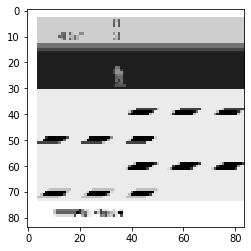

In [8]:
plt.imshow(state_0[3].cpu().numpy(), cmap='Greys')

In [9]:
s_0_np = state_0[3].cpu().numpy()

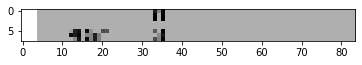

In [10]:
plt.imshow(s_0_np[4:12, :], cmap='Greys')

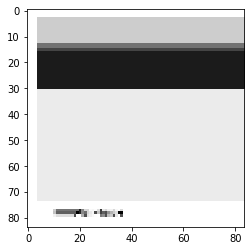

In [11]:
doctored_s_0_np = np.copy(s_0_np)
doctored_s_0_np[4:12,4:] = doctored_s_0_np[6,10]
doctored_s_0_np[16:31,4:] = doctored_s_0_np[20,10]
doctored_s_0_np[31:74,4:] = doctored_s_0_np[33,10]
plt.imshow(doctored_s_0_np, cmap='Greys')

## Starting to play around with color-based classifiers

In [12]:
NROWS = 1
NCOLS = 5
COL_WIDTH = 4
ROW_HEIGHT = 4 
WIDTH_SPACING = 0.5
HEIGHT_SPACING = 0


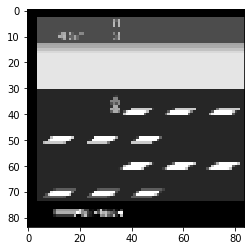

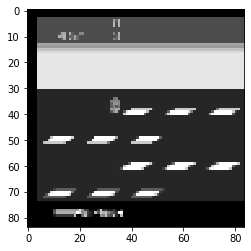

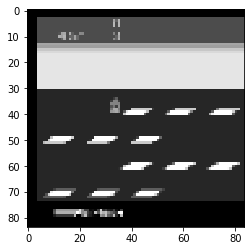

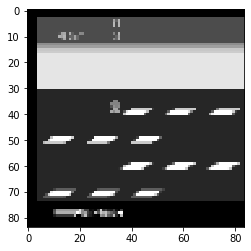

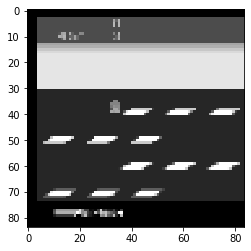

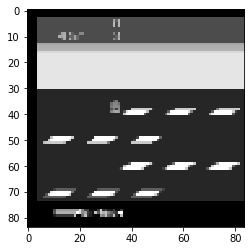

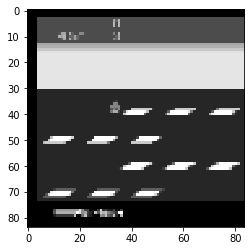

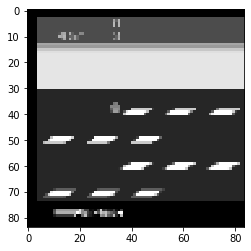

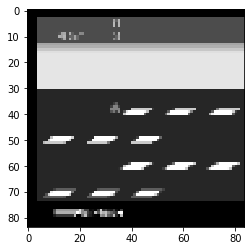

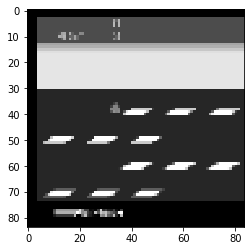

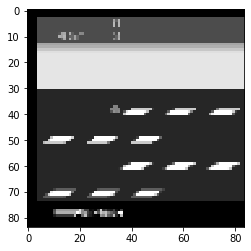

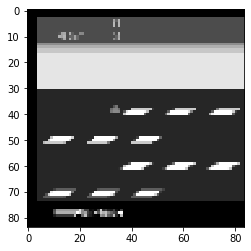

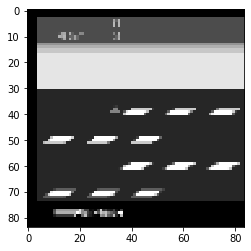

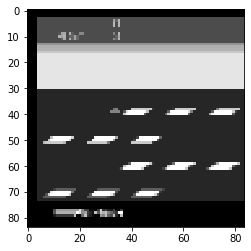

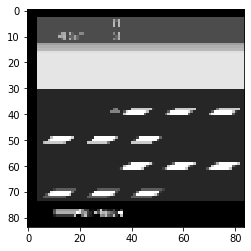

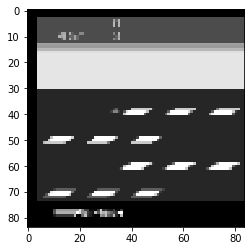

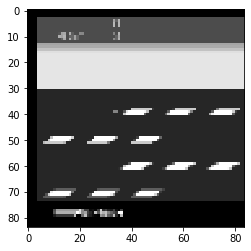

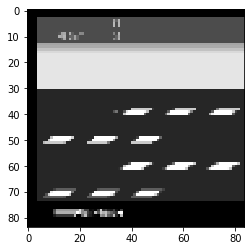

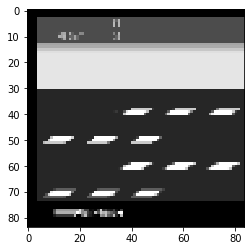

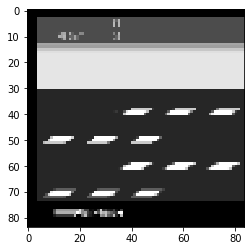

In [13]:
MIN_FRAME_TO_PLOT = 20

torch_states = []
np_states = []


val_mem = ReplayMemory(args, args.evaluation_size)
done = True
for frame in range(40):
    
    if done:
        state, done = env.reset(), False

    torch_states.append(state)
    np_state = state.cpu().numpy()
    np_states.append(np_state)
    
    if frame >= MIN_FRAME_TO_PLOT:
        plt.imshow(np_state[3], cmap='gray'); plt.show()
        
    next_state, _, done = env.step(np.random.randint(0, action_space))
    val_mem.append(state, None, None, done)
    state = next_state

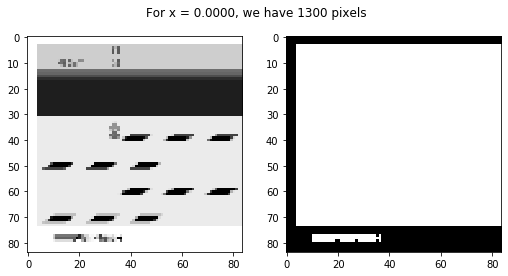

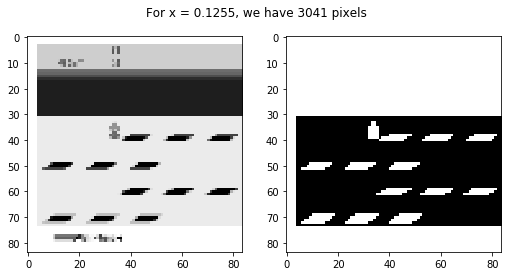

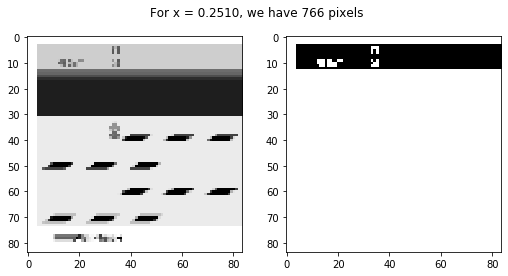

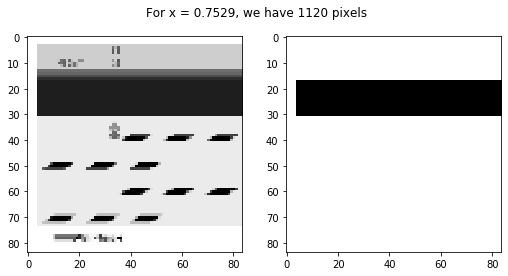

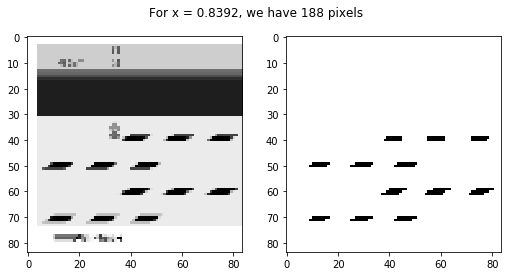

In [14]:
NCOLS = 2
NROWS = 1
INDEX = 20

state = np_states[INDEX][3]

for x in np.unique(state):
    count = np.sum(state == x)
#     print(x, count)
    if count > 100:
        state_figure = plt.figure(figsize=(NCOLS * COL_WIDTH + WIDTH_SPACING, NROWS * ROW_HEIGHT + HEIGHT_SPACING))
        plt.subplots_adjust(wspace=0.2)
        
        plt.suptitle(f'For x = {x:.4f}, we have {count} pixels')
        
        state_ax = plt.subplot(NROWS, NCOLS, 1)
        state_ax.imshow(state, cmap='Greys')
        
        mask_ax = plt.subplot(NROWS, NCOLS, 2)
        mask_ax.imshow((state == x).astype(np.uint8), cmap='Greys')
        

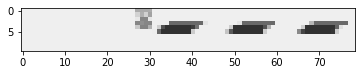

In [15]:
plt.imshow(state[35:45, 5:], cmap='Greys', norm=matplotlib.colors.Normalize(0, 1))

In [16]:
np.unique(state[35:45, 5:])

array([0.1254902 , 0.13725491, 0.16862746, 0.1764706 , 0.18823531,
       0.21568629, 0.2784314 , 0.28235295, 0.2901961 , 0.30588236,
       0.31764707, 0.34117648, 0.3921569 , 0.41176474, 0.4156863 ,
       0.41960788, 0.43137258, 0.45882356, 0.52156866, 0.54509807,
       0.5568628 , 0.5647059 , 0.62352943, 0.6627451 , 0.6745098 ,
       0.7176471 , 0.7411765 , 0.7490196 , 0.7843138 , 0.8078432 ,
       0.82745105, 0.83921576], dtype=float32)

In [17]:
for x in np.unique(state[35:45, 5:]):
    count = np.sum(state[35:45, 5:] == x)
    print(x, count)


0.1254902 683
0.13725491 1
0.16862746 1
0.1764706 1
0.18823531 2
0.21568629 1
0.2784314 1
0.28235295 1
0.2901961 1
0.30588236 5
0.31764707 1
0.34117648 1
0.3921569 1
0.41176474 1
0.4156863 1
0.41960788 1
0.43137258 4
0.45882356 1
0.52156866 1
0.54509807 1
0.5568628 5
0.5647059 2
0.62352943 1
0.6627451 25
0.6745098 1
0.7176471 1
0.7411765 1
0.7490196 1
0.7843138 1
0.8078432 1
0.82745105 1
0.83921576 40


In [18]:
raw_screen = np.squeeze(env.ale.getScreenGrayscale())

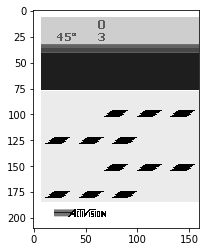

In [19]:
plt.imshow(raw_screen, cmap='Greys')

In [20]:
for x in np.unique(raw_screen):
    count = np.sum(raw_screen == x)
    print(x, count)

0 6463
32 14920
64 3854
90 20
131 37
132 31
136 152
143 152
146 152
149 152
150 152
153 112
167 456
192 5320
193 169
214 1458


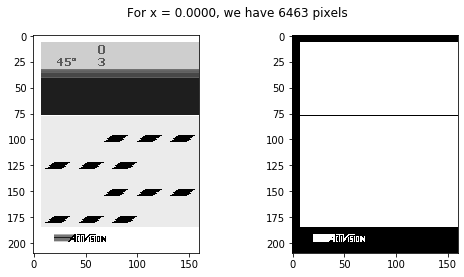

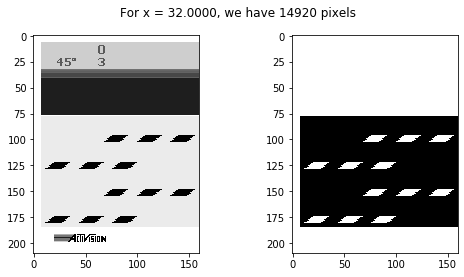

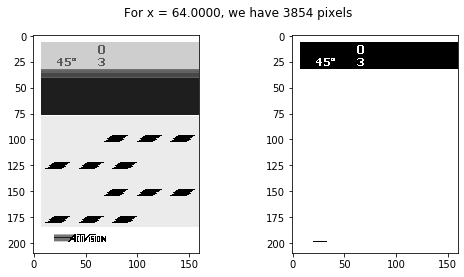

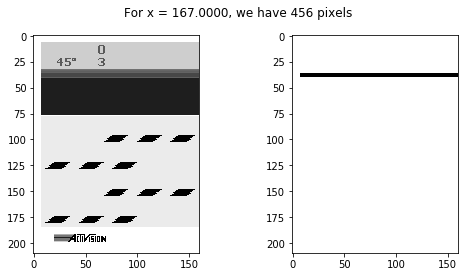

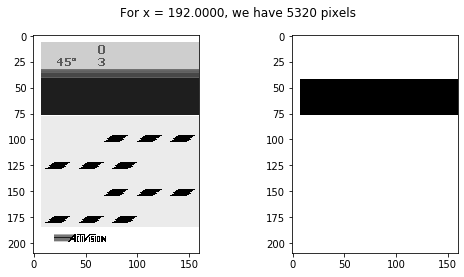

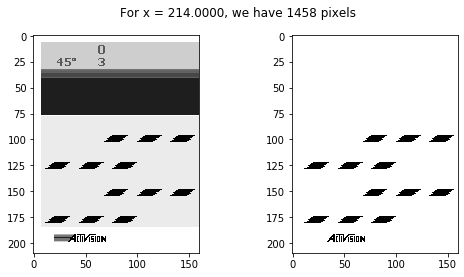

In [21]:
for x in np.unique(raw_screen):
    count = np.sum(raw_screen == x)
#     print(x, count)
    if count > 250:
        state_figure = plt.figure(figsize=(NCOLS * COL_WIDTH + WIDTH_SPACING, NROWS * ROW_HEIGHT + HEIGHT_SPACING))
        plt.subplots_adjust(wspace=0.2)
        
        plt.suptitle(f'For x = {x:.4f}, we have {count} pixels')
        
        state_ax = plt.subplot(NROWS, NCOLS, 1)
        state_ax.imshow(raw_screen, cmap='Greys')
        
        mask_ax = plt.subplot(NROWS, NCOLS, 2)
        mask_ax.imshow((raw_screen == x).astype(np.uint8), cmap='Greys')

## Starting to mess around with the saved state traces

In [22]:
def load_saved_states(seed, num=0, name='baseline-rainbow', color=False):
    state_type = color and 'color' or 'gray'
    path_glob = os.path.join('../results', f'{name}-{seed}', 'evaluation/states', f'*{num}-{state_type}.pickle')
    path = glob.glob(path_glob)[0]
    
    with open(path, 'rb') as pickle_file:
        return pickle.load(pickle_file)
                        

In [83]:
states_300_0_gray = load_saved_states(300)
print(states_300_0_gray.shape)

states_300_0_color = load_saved_states(300, color=True)
states_300_0_color.shape

(2309, 210, 160)


(2309, 3, 210, 160)

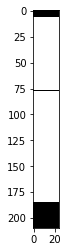

In [70]:
plt.imshow(states_300_0_gray[0,:,-25:], cmap='gray', norm=matplotlib.colors.Normalize(0, 1))

## Let's print out every 50th state to get some exemplars

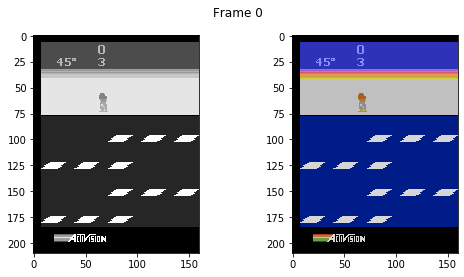

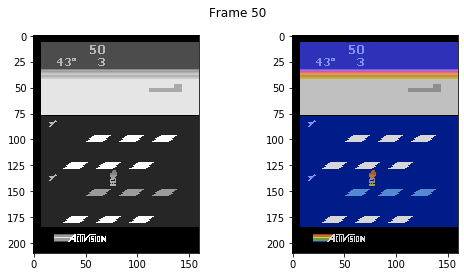

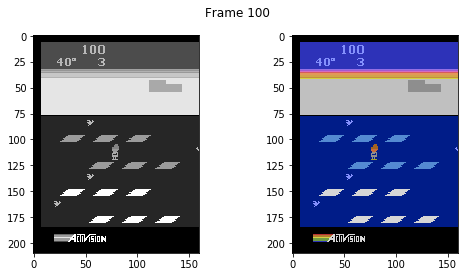

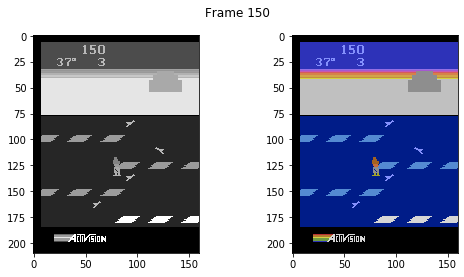

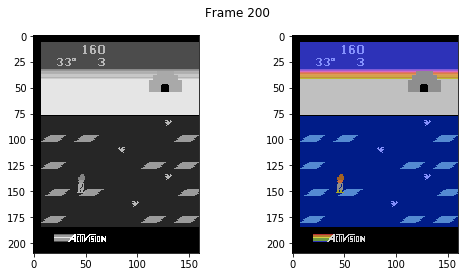

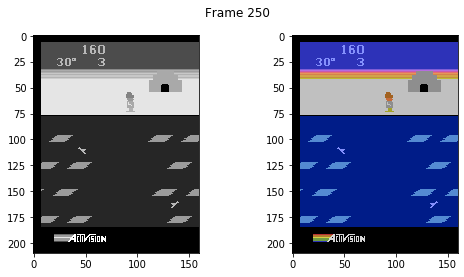

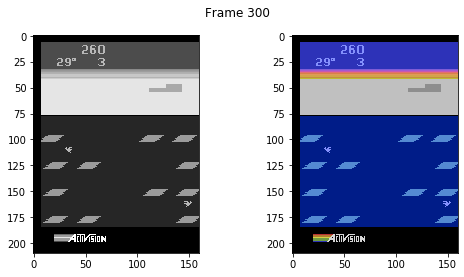

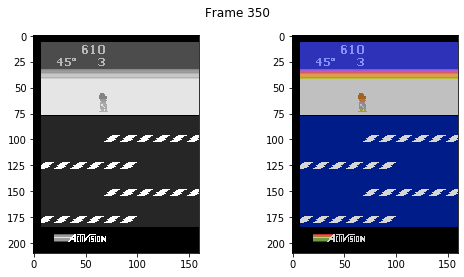

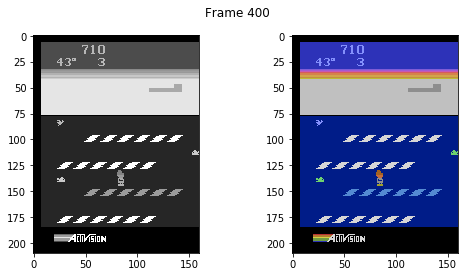

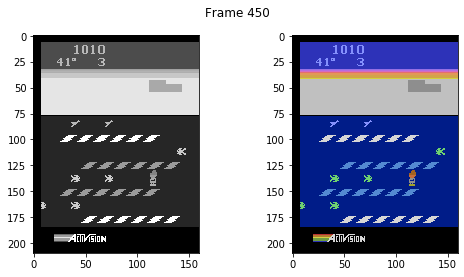

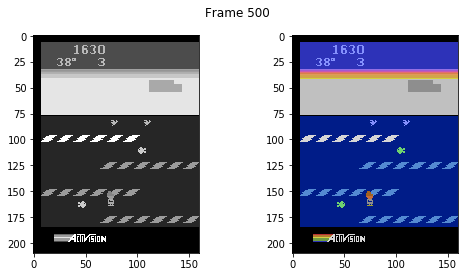

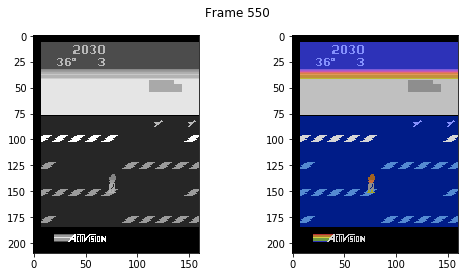

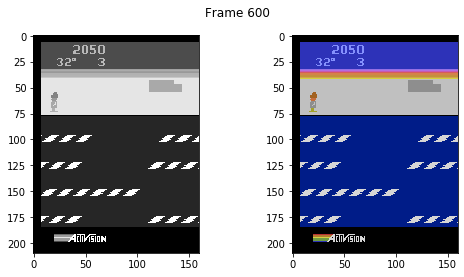

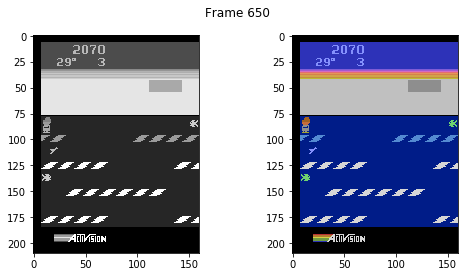

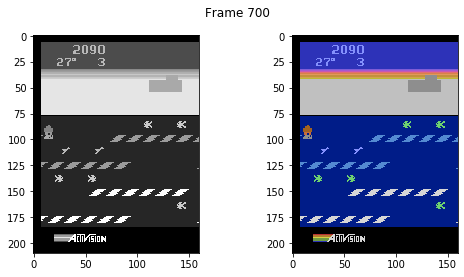

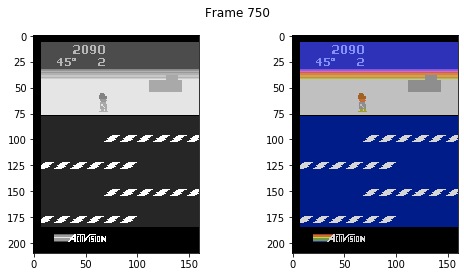

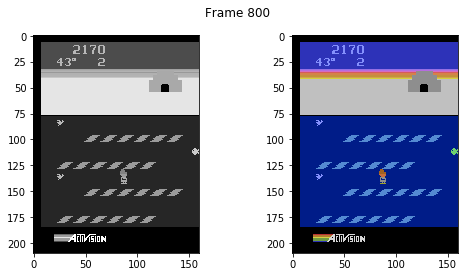

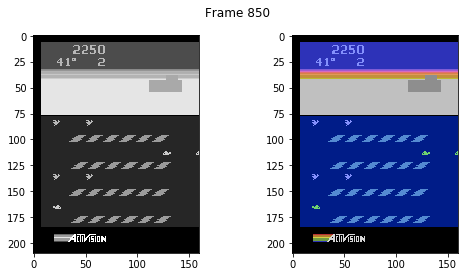

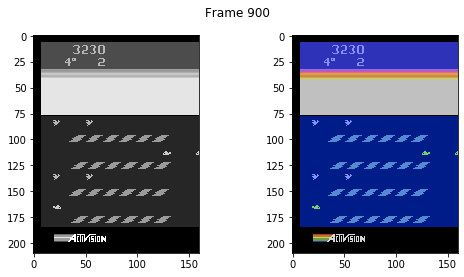

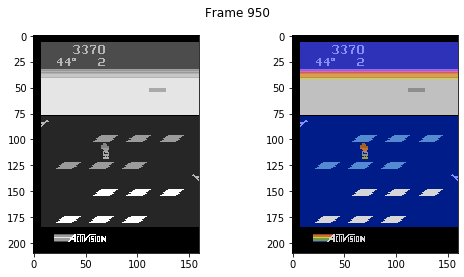

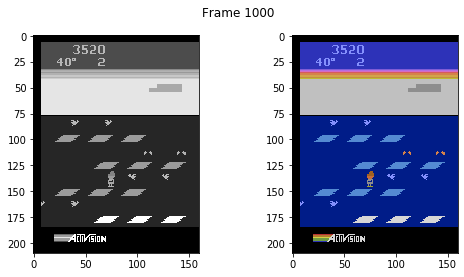

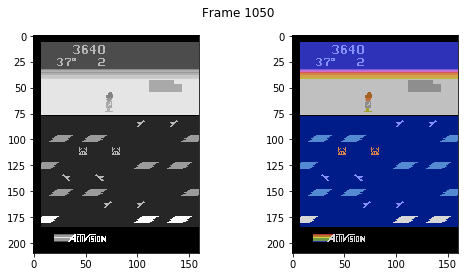

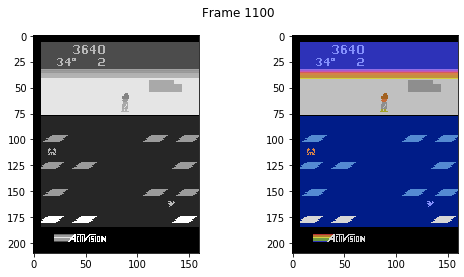

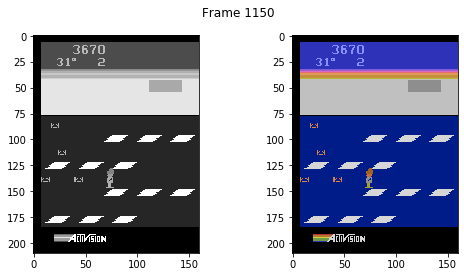

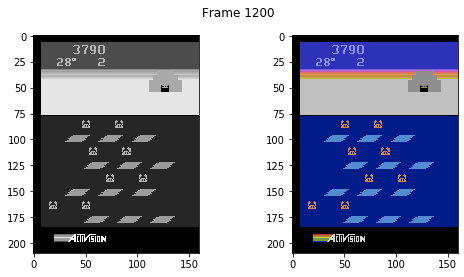

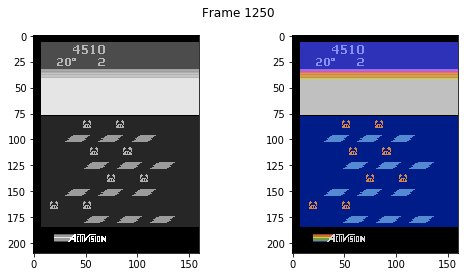

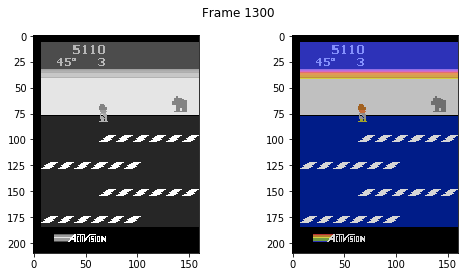

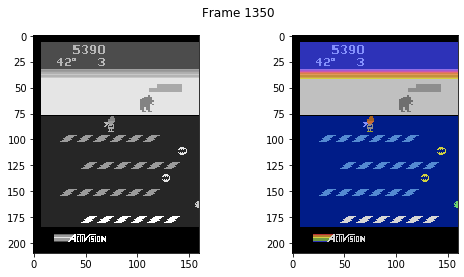

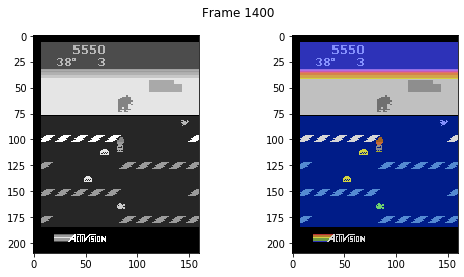

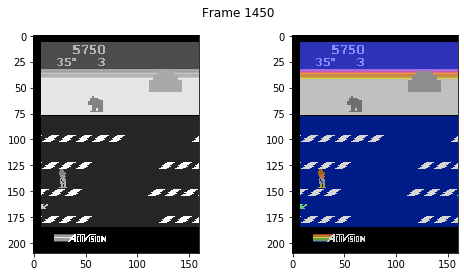

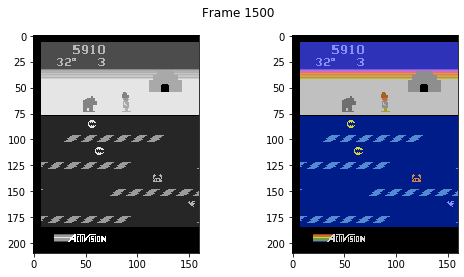

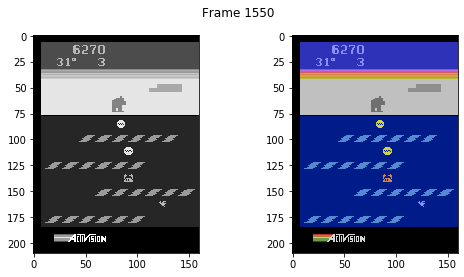

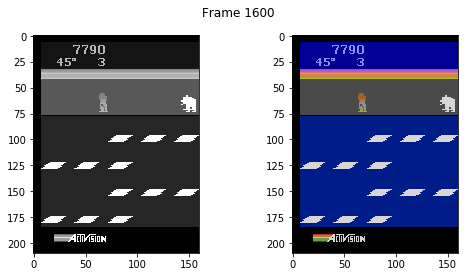

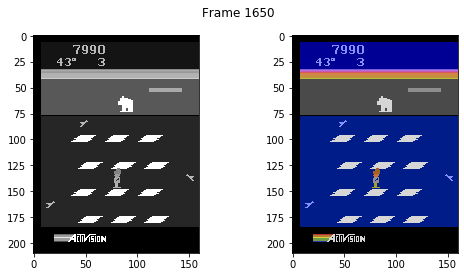

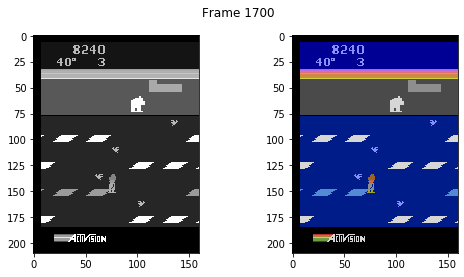

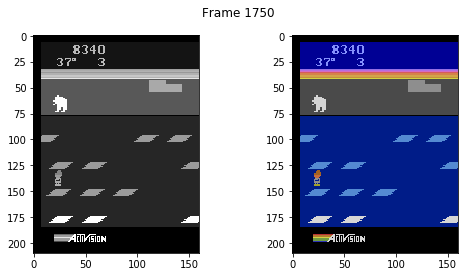

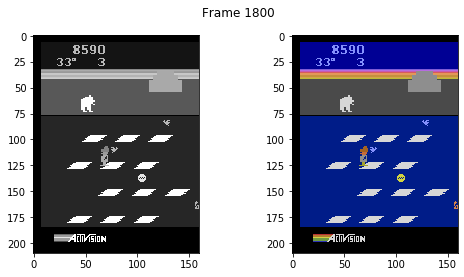

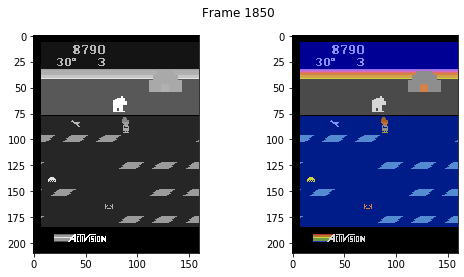

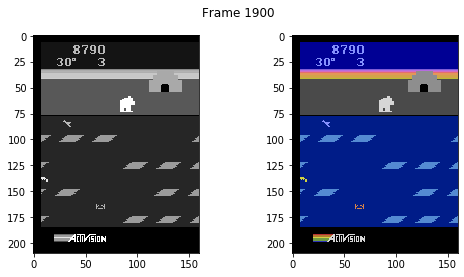

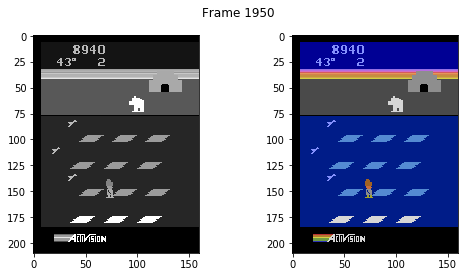

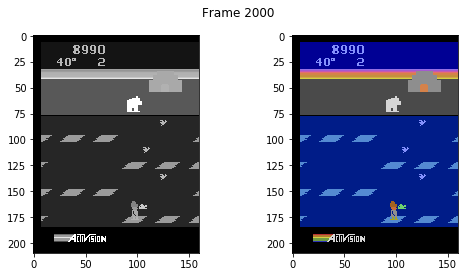

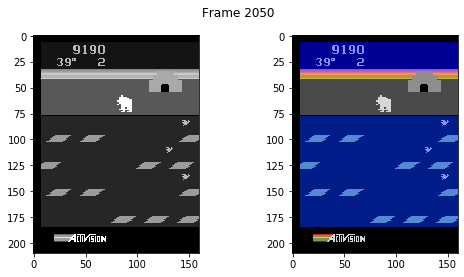

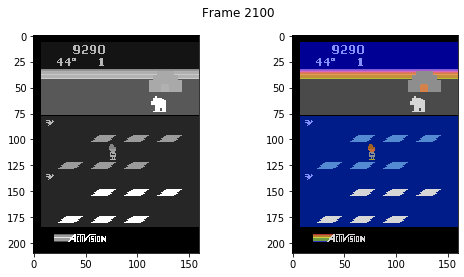

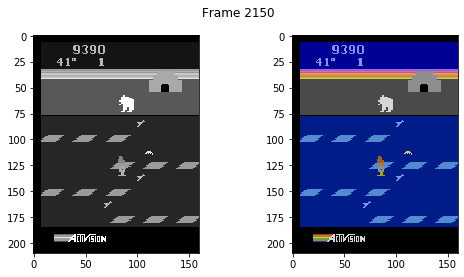

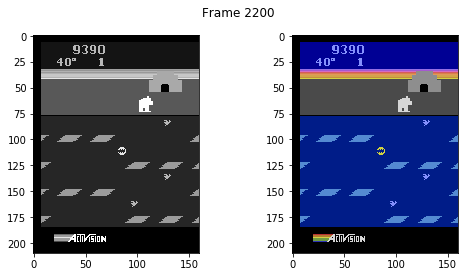

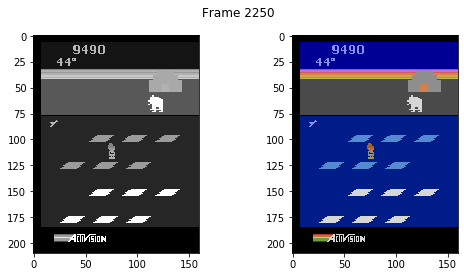

In [122]:
for i in range(0, 2300, 50):
    state_figure = plt.figure(figsize=(NCOLS * COL_WIDTH + WIDTH_SPACING, NROWS * ROW_HEIGHT + HEIGHT_SPACING))
    plt.subplots_adjust(wspace=0.2)

    plt.suptitle(f'Frame {i}')

    gray_ax = plt.subplot(NROWS, NCOLS, 1)
    gray_ax.imshow(states_300_0_gray[i], cmap='gray')

    color_ax = plt.subplot(NROWS, NCOLS, 2)
    color_ax.imshow(np.moveaxis(states_300_0_color[i], 0, 2))
    
    plt.show()

## Generate color lists for each semantic type of objects

In [ ]:
player_colors = (110, 116, 129, 148, )
# masking the player won't work by color, but perhaps by color + shape around?
floe_colors = (130, 214)
# 153 also captures the score, so perhaps that needs to be better spatially limited
# 148 also captures some of the player, so perhaps we need to mutually exclude with where we infer the player to be?
# 214 captures both the bear in the black background and the white floes, so another spatial limitation?
bad_animal_colors = (153, # birds
                     148, # crabs
                     111, # bear in white background
                     193, # angry yellow things
                     214, # bear in black background
                    ) 
good_animal_colors = (169, # fish
                     )

# The door is harder to capture straight up by color, as it matches with a black row below the snow
# Maybe this would be trivial in color?

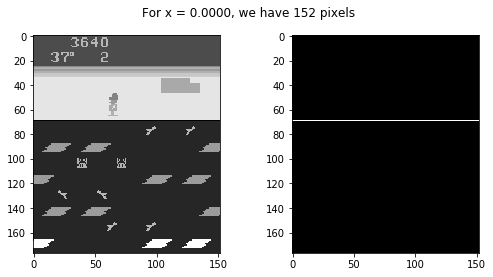

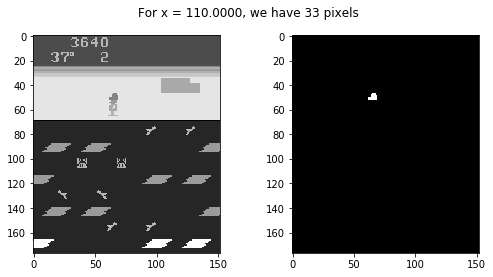

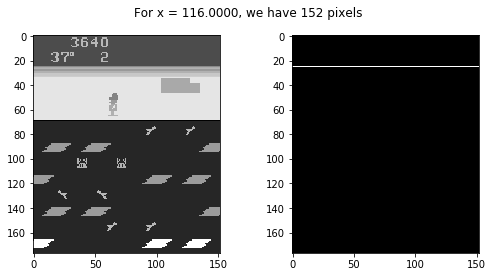

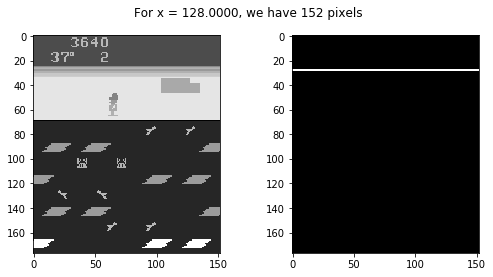

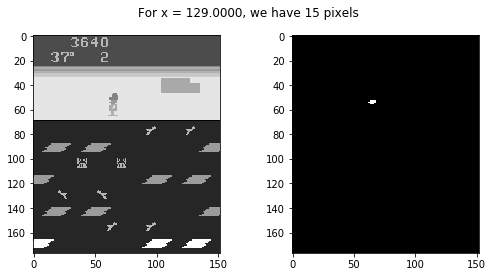

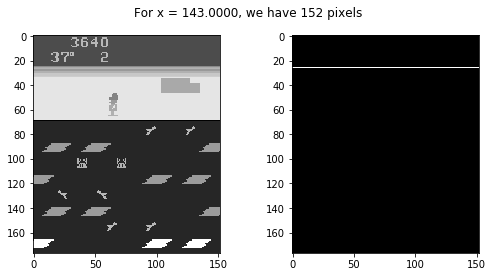

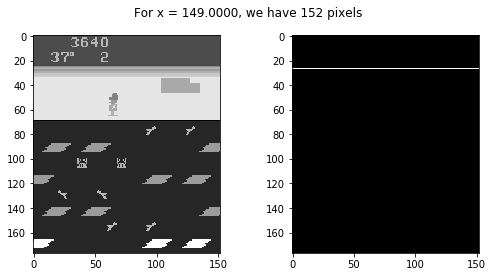

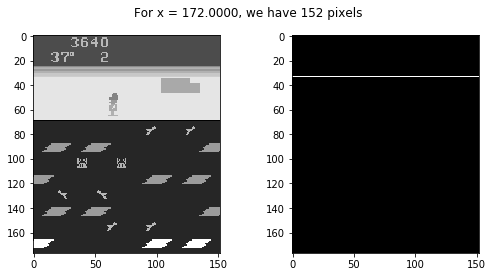

In [133]:
index = 1050

min_count = 1
max_count = 200

frame_row_min = 8
frame_row_max = -25

frame_col_min = 8
frame_col_max = None

full_frame = states_300_0_gray[index]
frame = full_frame[frame_row_min:frame_row_max, frame_col_min:frame_col_max]

for x in np.unique(frame):
    count = np.sum(frame == x)
#     print(x, count)
    if min_count < count < max_count:
        state_figure = plt.figure(figsize=(NCOLS * COL_WIDTH + WIDTH_SPACING, NROWS * ROW_HEIGHT + HEIGHT_SPACING))
        plt.subplots_adjust(wspace=0.2)
        
        plt.suptitle(f'For x = {x:.4f}, we have {count} pixels')
        
        state_ax = plt.subplot(NROWS, NCOLS, 1)
        state_ax.imshow(frame, cmap='gray')
        
        mask_ax = plt.subplot(NROWS, NCOLS, 2)
        mask_ax.imshow((frame == x).astype(np.uint8), cmap='gray')

## Same thing but in color

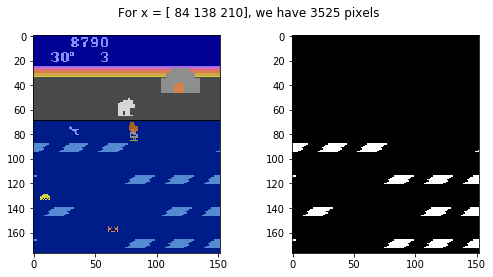

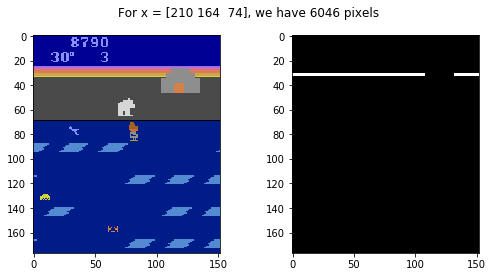

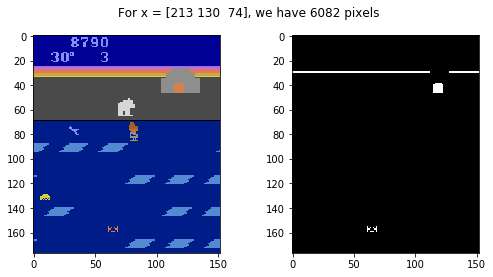

In [179]:
index = 1850

frame_row_min = 8
frame_row_max = -25

frame_col_min = 8
frame_col_max = None

min_count = 2000
max_count = 10000

full_frame = states_300_0_color[index]
frame = full_frame[:, frame_row_min:frame_row_max, frame_col_min:frame_col_max]
# frame = full_frame

flattened = frame.reshape(3, -1)

for x in np.unique(flattened, axis=1).T:
    count = np.sum(np.equal(flattened, x.reshape(3, 1)))
#     print(x, count)
    if min_count < count < max_count:
        state_figure = plt.figure(figsize=(NCOLS * COL_WIDTH + WIDTH_SPACING, NROWS * ROW_HEIGHT + HEIGHT_SPACING))
        plt.subplots_adjust(wspace=0.2)
        
        plt.suptitle(f'For x = {x}, we have {count} pixels')
        
        state_ax = plt.subplot(NROWS, NCOLS, 1)
        state_ax.imshow(np.moveaxis(frame, 0, 2))
        
        mask_ax = plt.subplot(NROWS, NCOLS, 2)
        mask_ax.imshow((np.all(np.equal(frame, x.reshape(3, 1, 1)), axis=0)).astype(np.uint8), cmap='gray')

In [223]:
frame_row_min = 8
frame_row_max = -25

frame_col_min = 8
frame_col_max = None

frame_shape = (177, 152)

player_colors = ((162, 98, 33),
                 (162, 162, 42),
                 (198, 108, 58),
                 (142, 142, 142) # also captures the igloo
                )

floe_colors = ((84, 138, 210), # visited floes
               (214, 214, 214), # unvisited_floes
              ) 

bad_animal_colors = ((132, 144, 252), # birds -- also captures the score!
                     (213, 130, 74), # crabs -- no more conflict with the player
                     (210, 210, 64), # angry yellow things
                    ) 

bear_colors = ((111, 111, 111), # bear in white background
               (214, 214, 214), # bear in black background -- same as the unvisited floes
              )

good_animal_colors = ((111, 210, 111), # fish
                     )

animal_subframe_row_min = 70

igloo_colors = ((142, 142, 142),
                # isolating the igloo door is harder - its black and orange colors both conflict
                )

igloo_subframe_row_min = 26
igloo_subframe_row_max = 47
igloo_row_range = (igloo_subframe_row_min, igloo_subframe_row_max)

igloo_subframe_col_min = 104
igloo_subframe_col_max = 136
igloo_col_range = (igloo_subframe_col_min, igloo_subframe_col_max)

# The igloo's black also conflicts with a black line below the ice, so we to do the igloo we would location
# Same with the birds, which conflict with the score
# Player also conflict with igloo, which I guess we could also resolve with location 



## Writing a class to do this sort of filtering

In [203]:
class ColorFilterMasker:
    def __init__(self, filter_colors, row_range=(None, None), col_range=(None, None), range_whitelist=True):
        self.filter_colors = [np.array(x).reshape(1, 1, 3) for x in filter_colors]
        self.row_range = row_range
        self.col_range = col_range
        self.range_whitelist = range_whitelist
        
    def __call__(self, frame):
        """
        Assumes the frame is of the form [h, w, c]
        """
        masks = [(np.all(np.equal(frame, color), axis=2)).astype(np.uint8) for color in self.filter_colors]
        mask = np.any(masks, axis=0)
        
        if np.any((self.row_range, self.col_range)) is not None:
            if self.range_whitelist:
                mask[:self.row_range[0],:] = 0
                mask[self.row_range[1]:,:] = 0
                mask[:,:self.col_range[0]] = 0
                mask[:,self.col_range[1]:] = 0
                
            else:
                mask[self.row_range[0]:self.row_range[1],self.col_range[0]:self.col_range[1]] = 0
                
        return mask

In [226]:
player_masker = ColorFilterMasker(player_colors, igloo_row_range, igloo_col_range, range_whitelist=False)
floe_masker = ColorFilterMasker(floe_colors, (animal_subframe_row_min, frame_shape[0]),
                                     (0, frame_shape[1]))
bad_animal_masker = ColorFilterMasker(bad_animal_colors, (animal_subframe_row_min, frame_shape[0]),
                                     (0, frame_shape[1]))
good_animal_masker = ColorFilterMasker(good_animal_colors)
bear_filter = ColorFilterMasker(bear_colors, (0, animal_subframe_row_min), (0, frame_shape[1]))
igloo_masker = ColorFilterMasker(igloo_colors, igloo_row_range, igloo_col_range)


### Printing out a frame and all of its masks

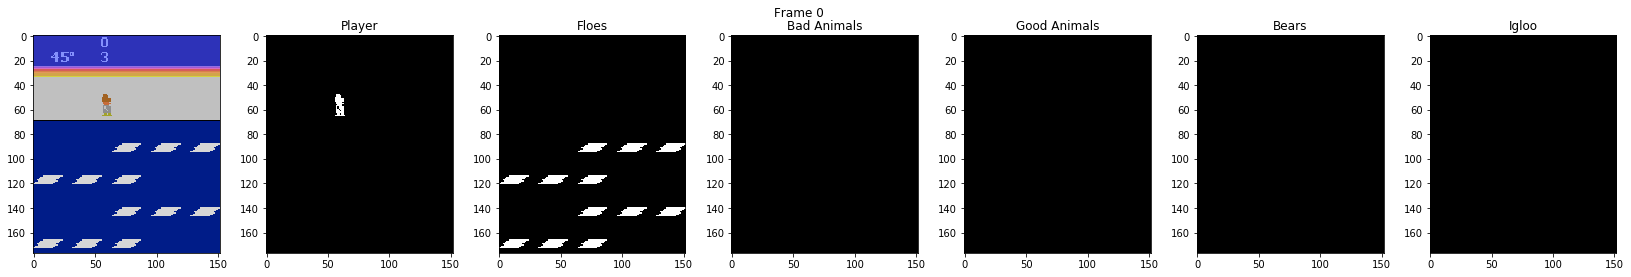

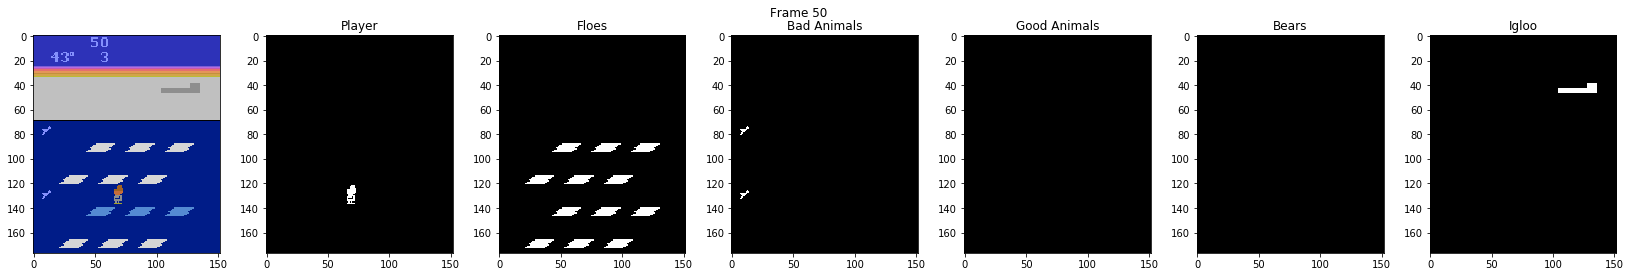

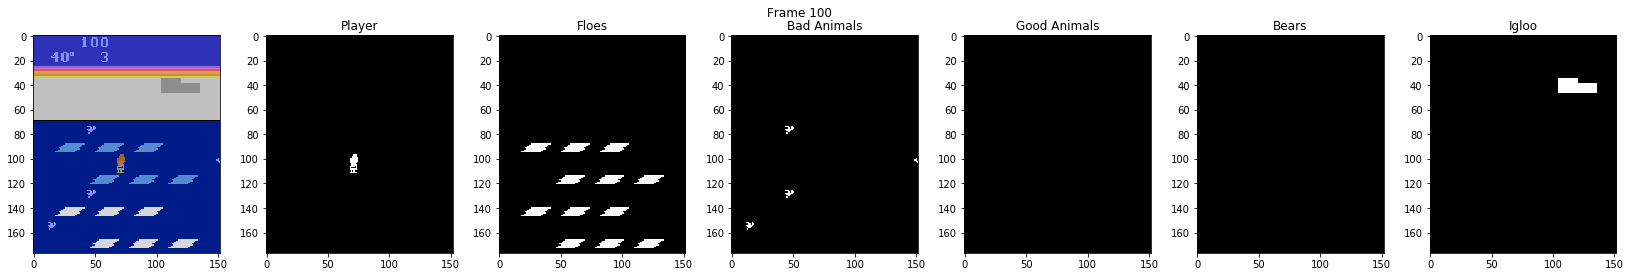

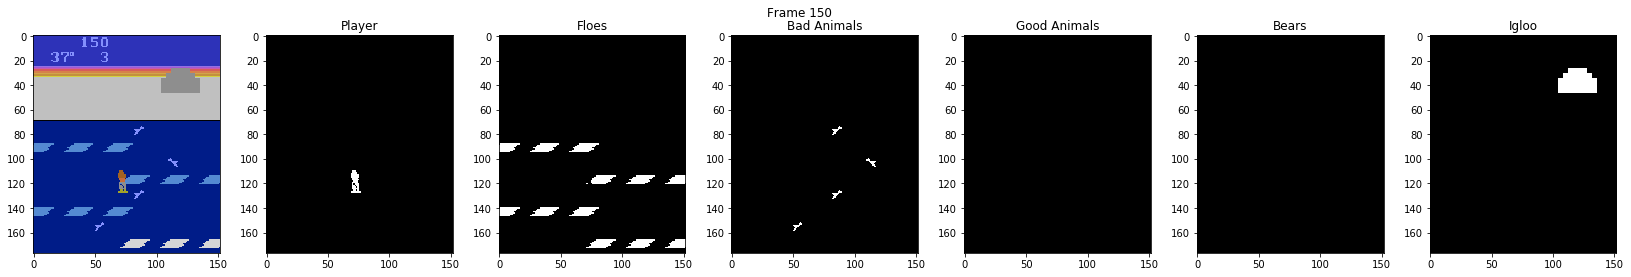

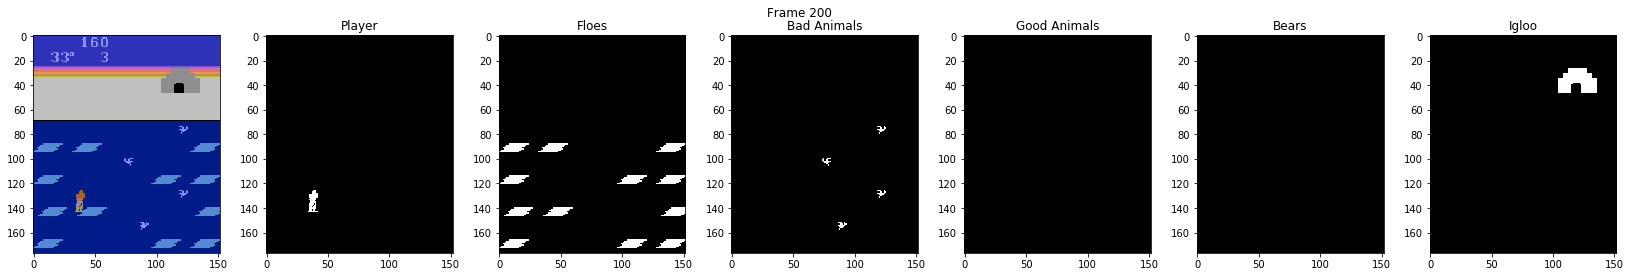

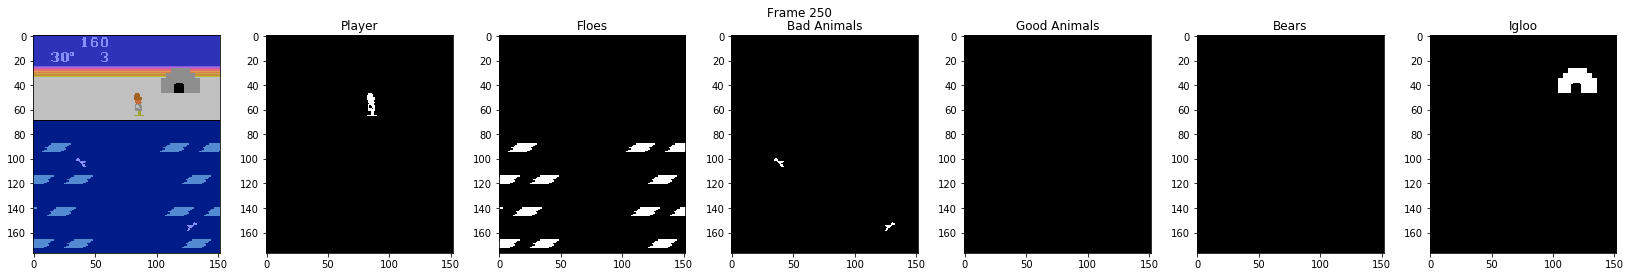

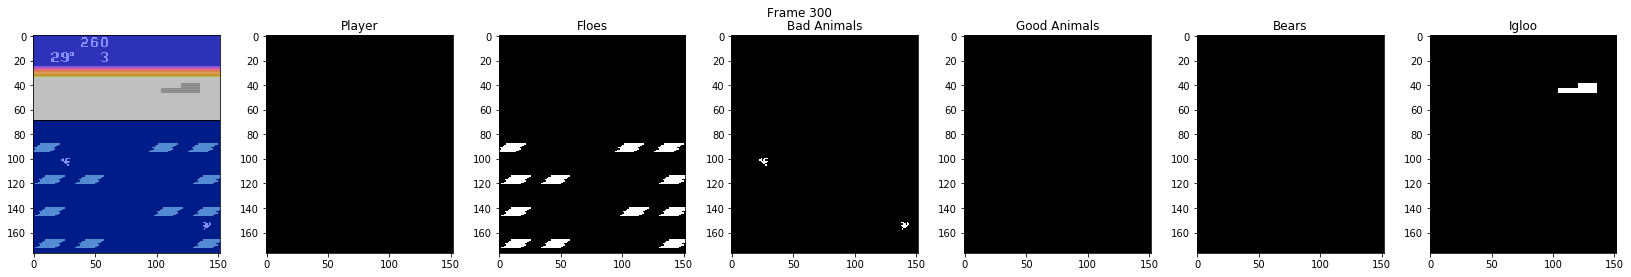

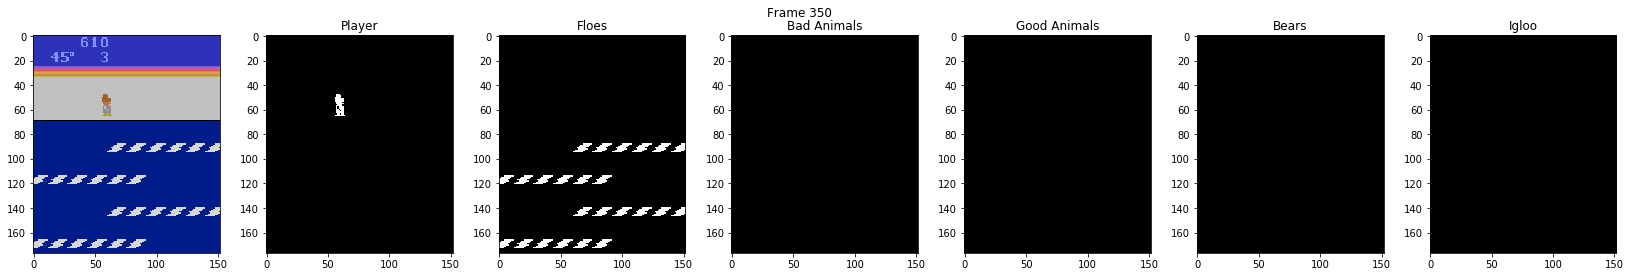

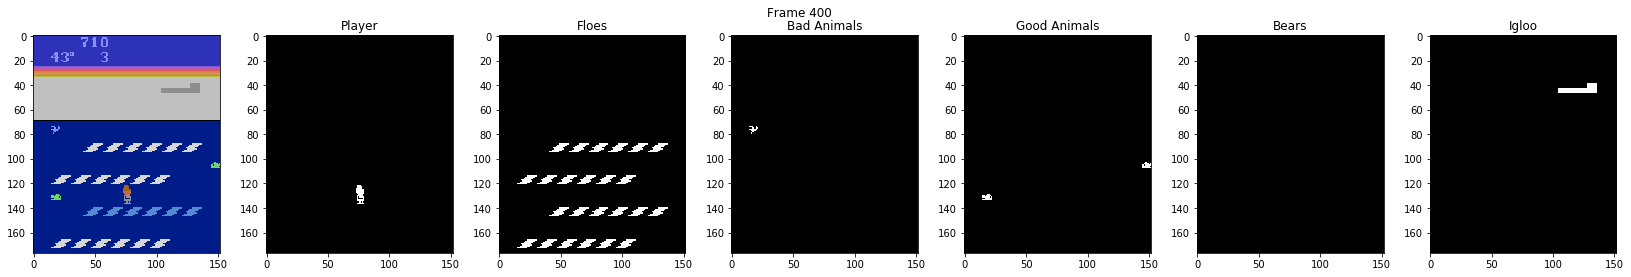

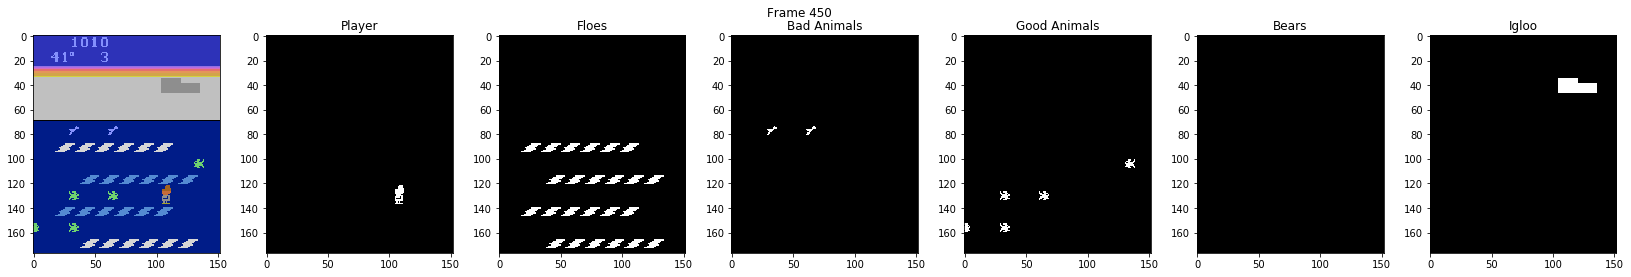

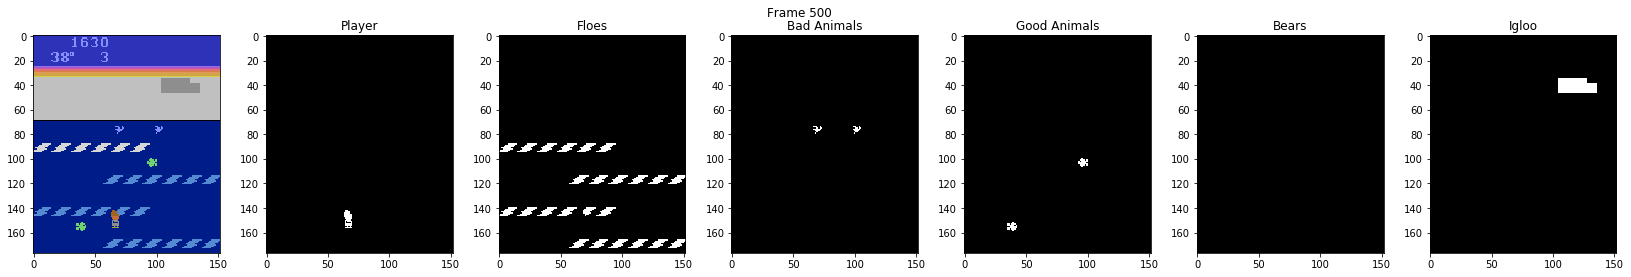

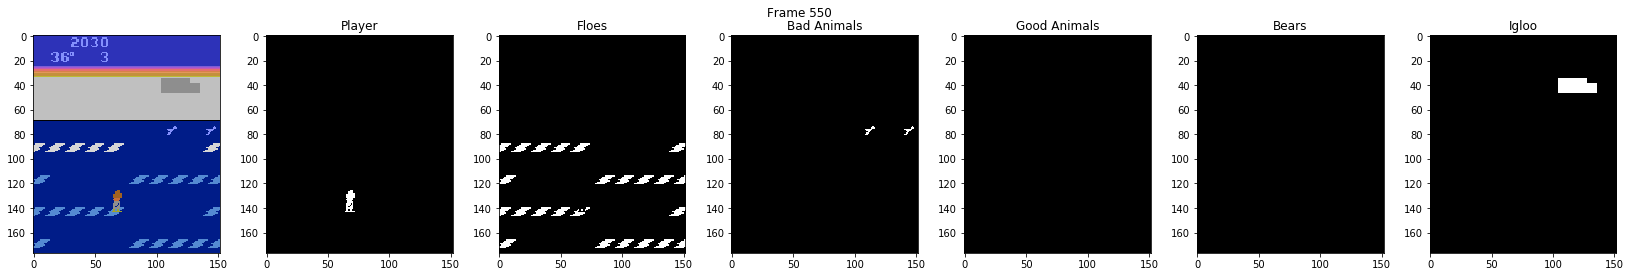

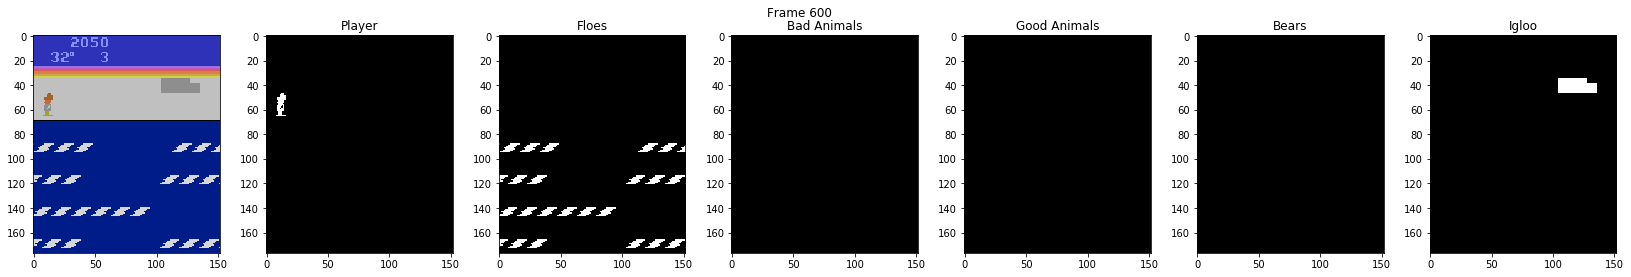

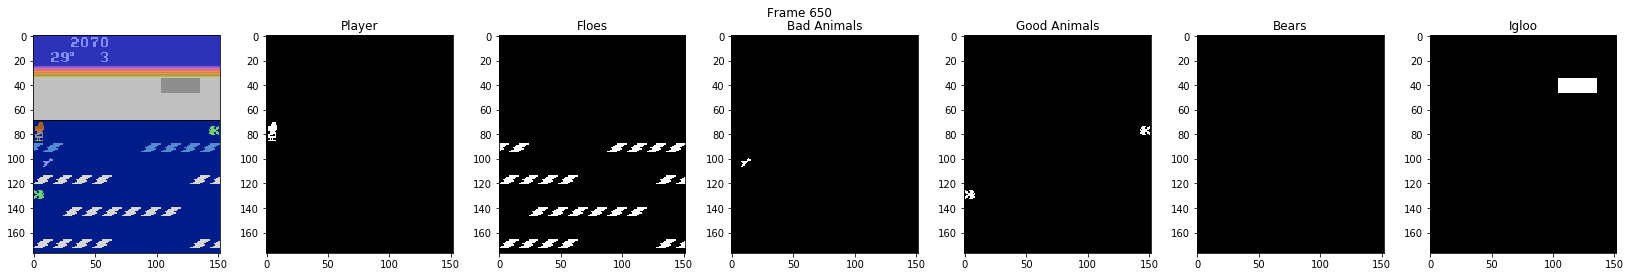

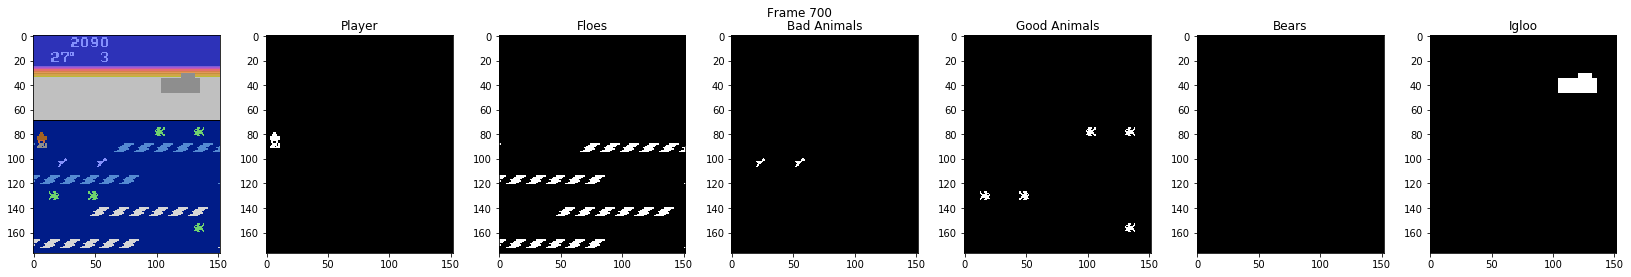

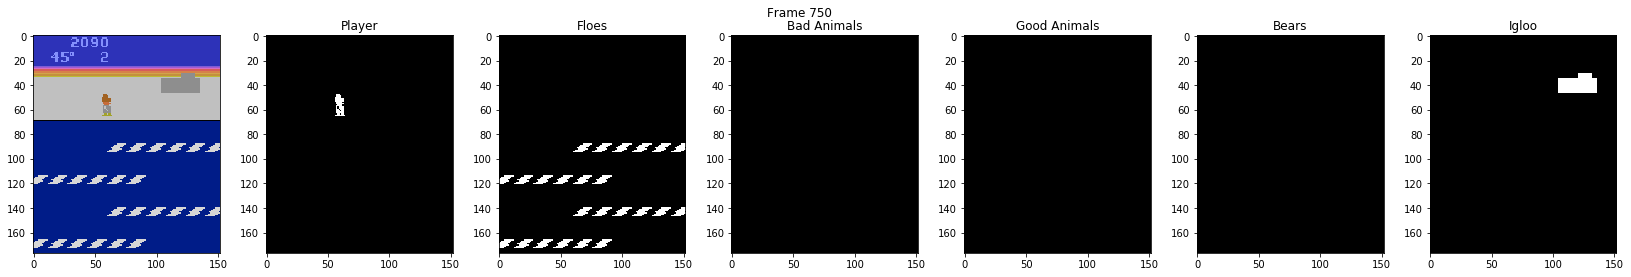

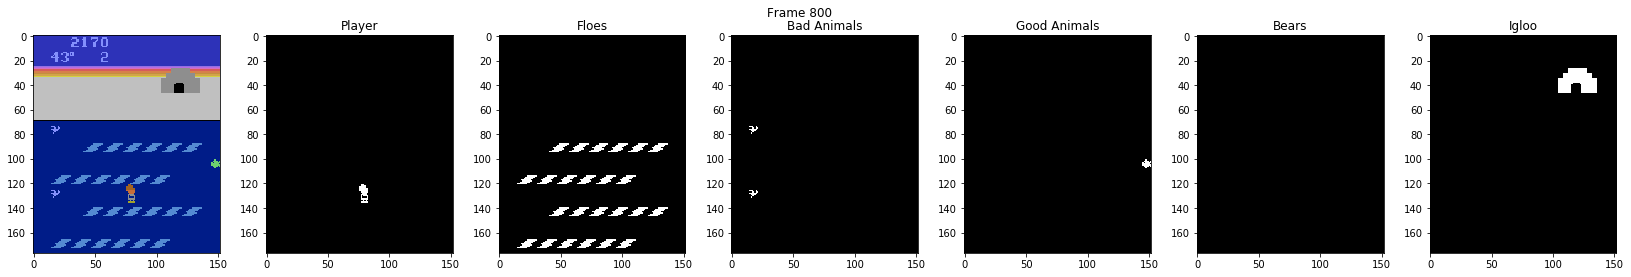

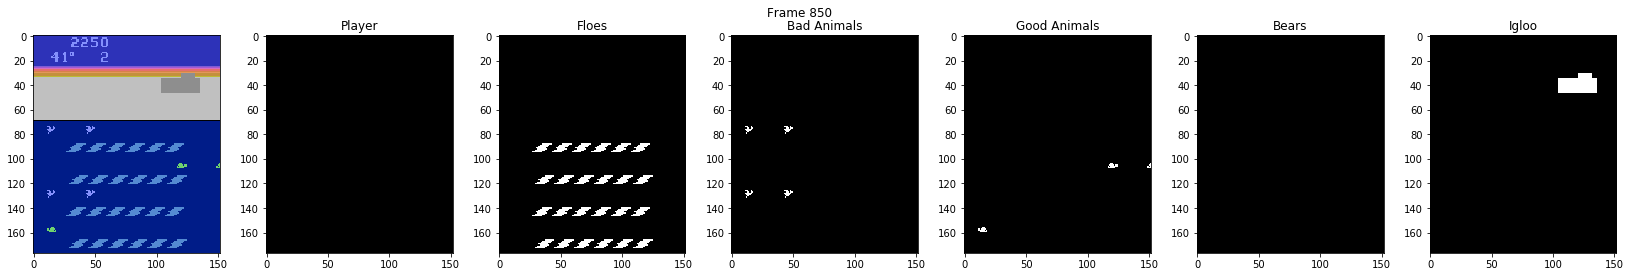

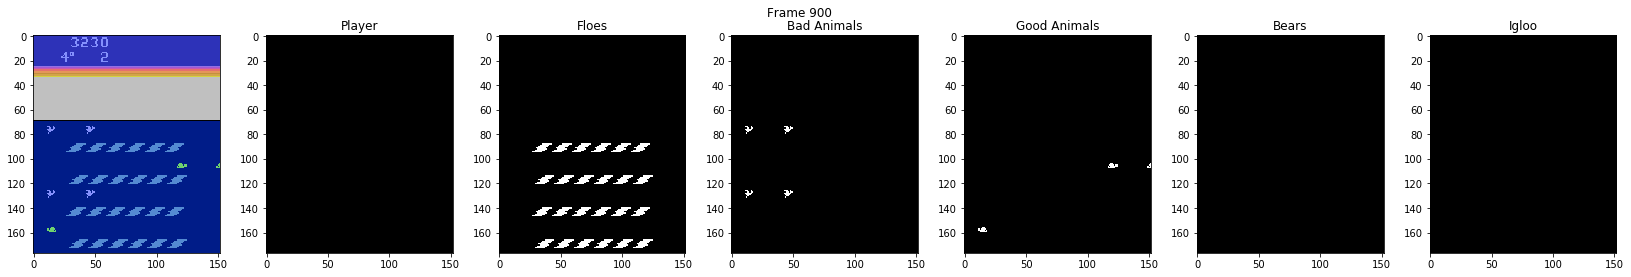

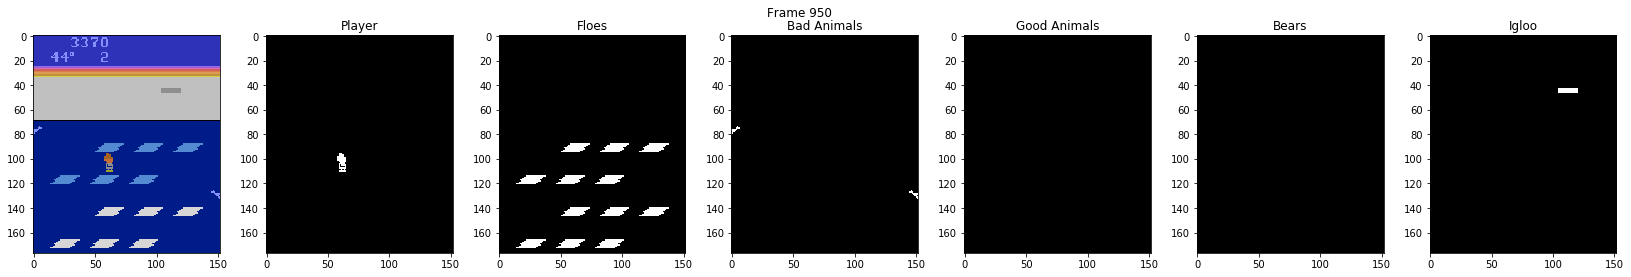

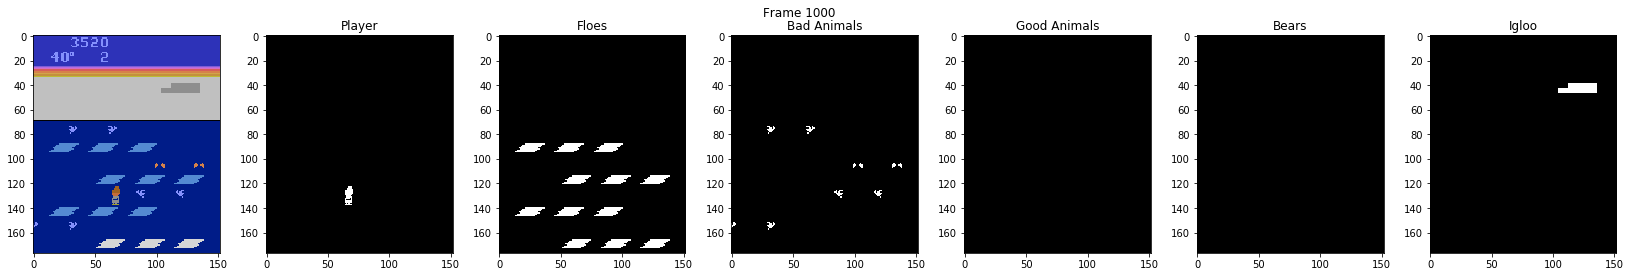

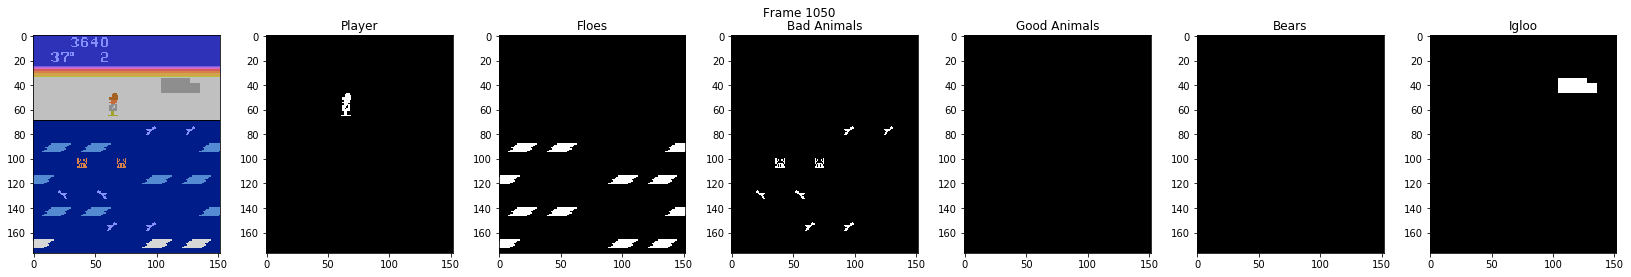

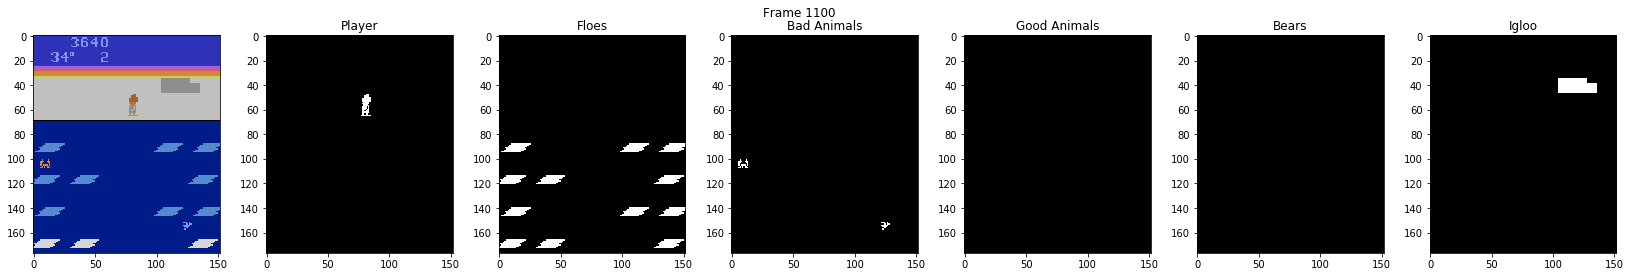

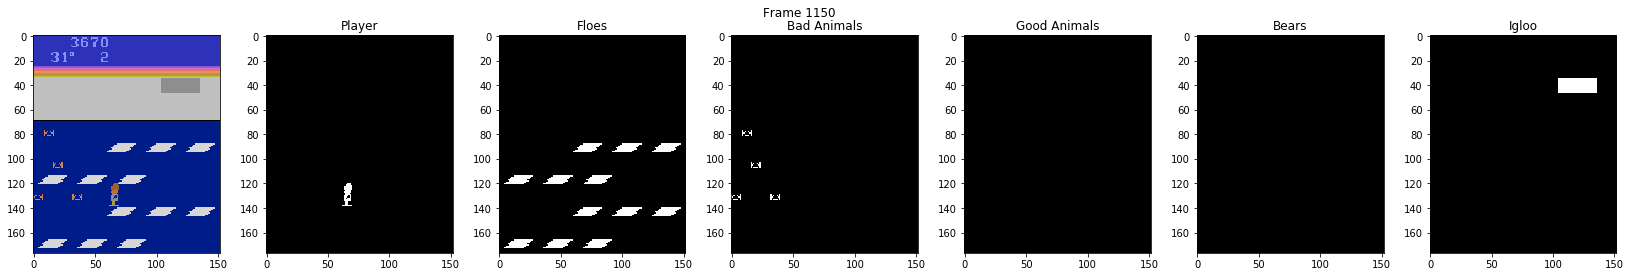

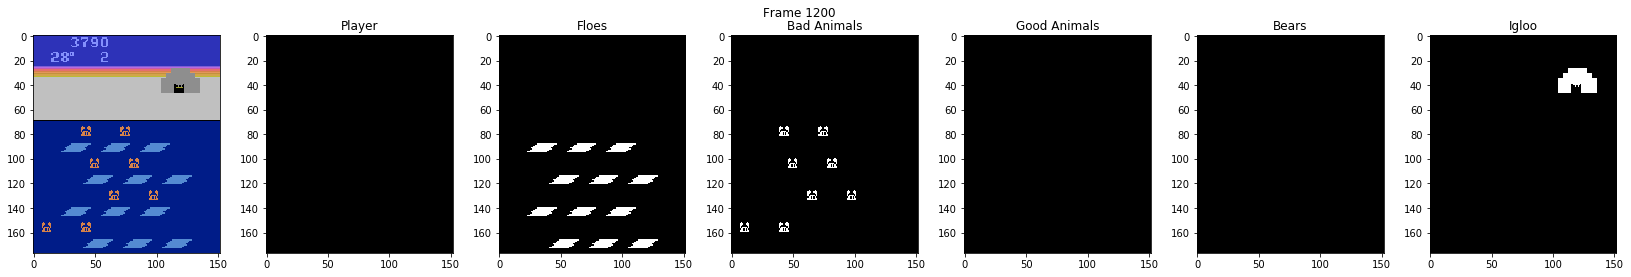

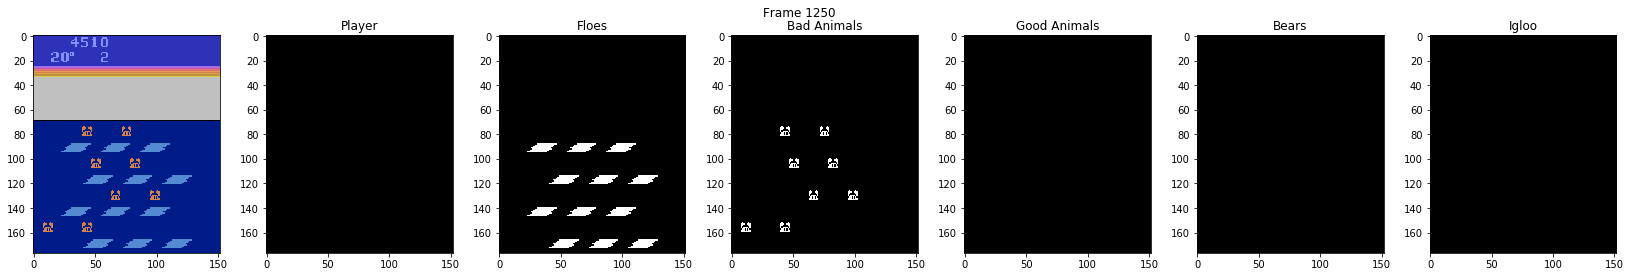

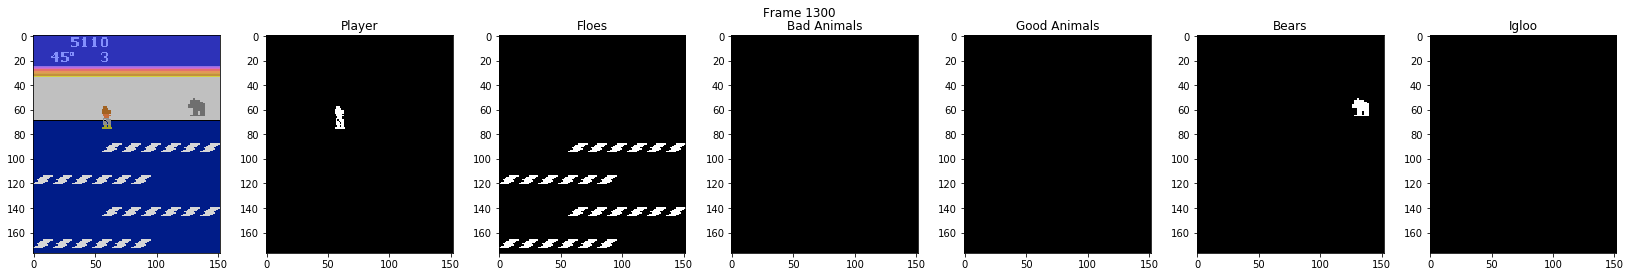

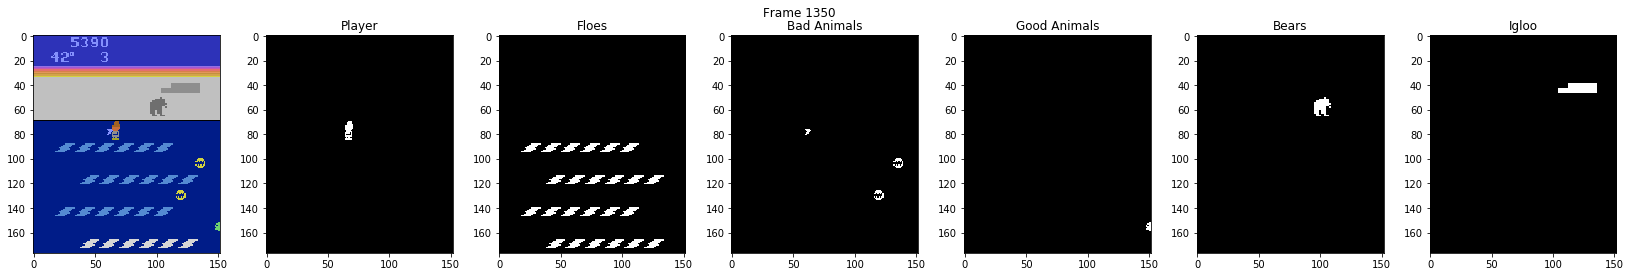

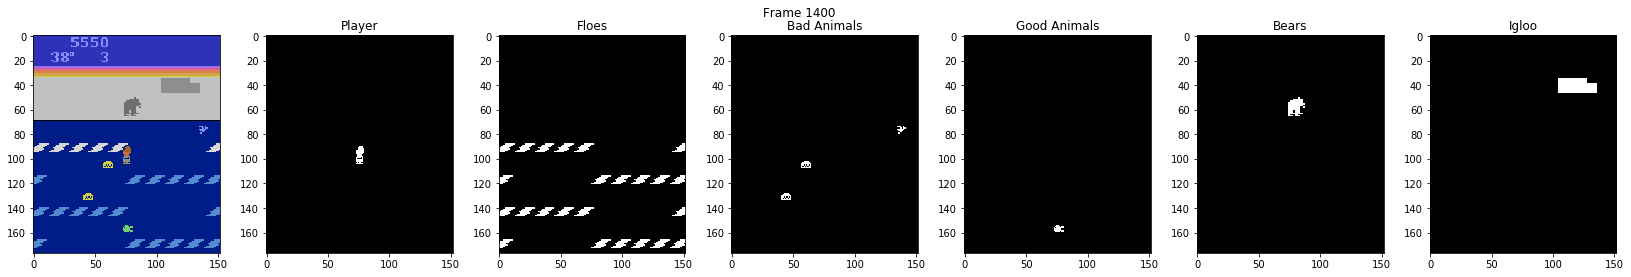

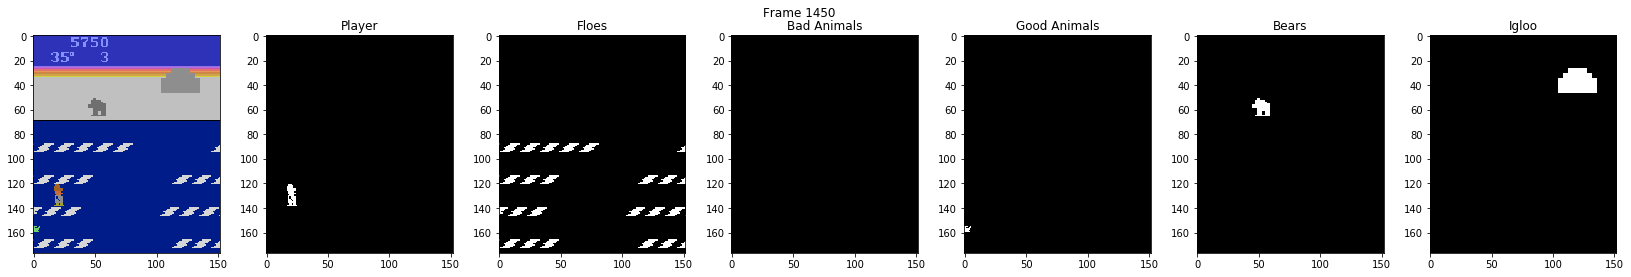

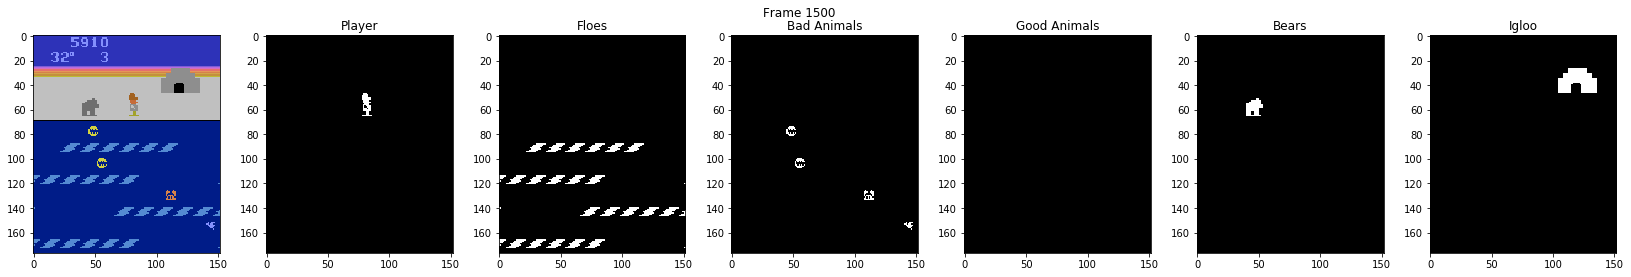

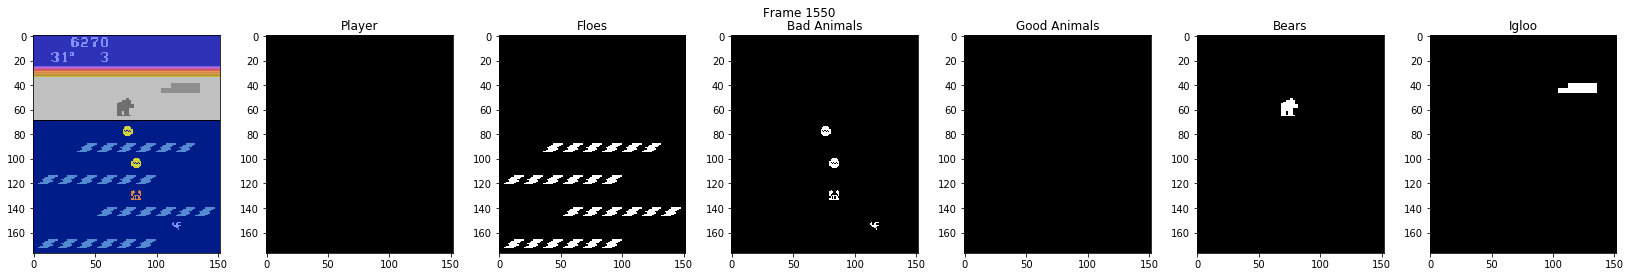

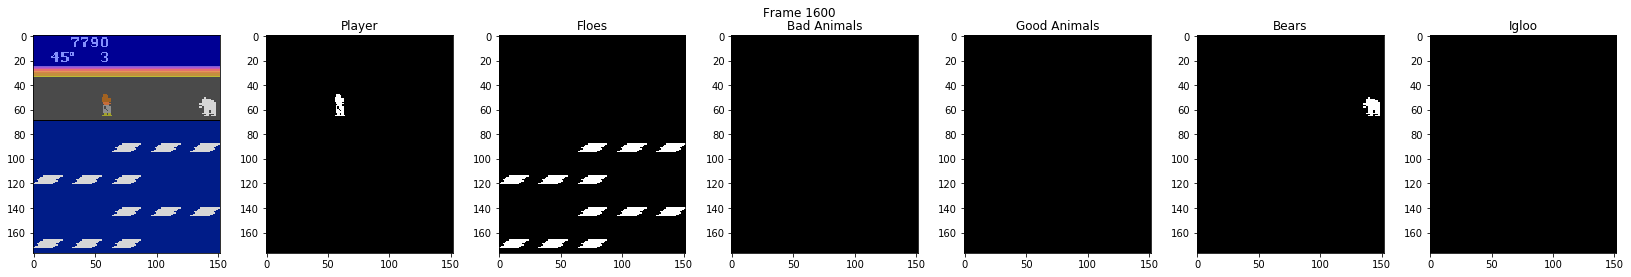

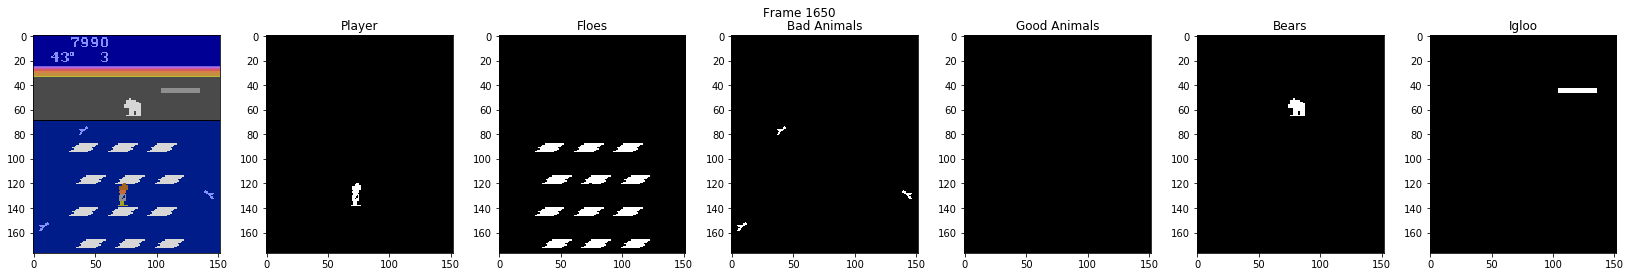

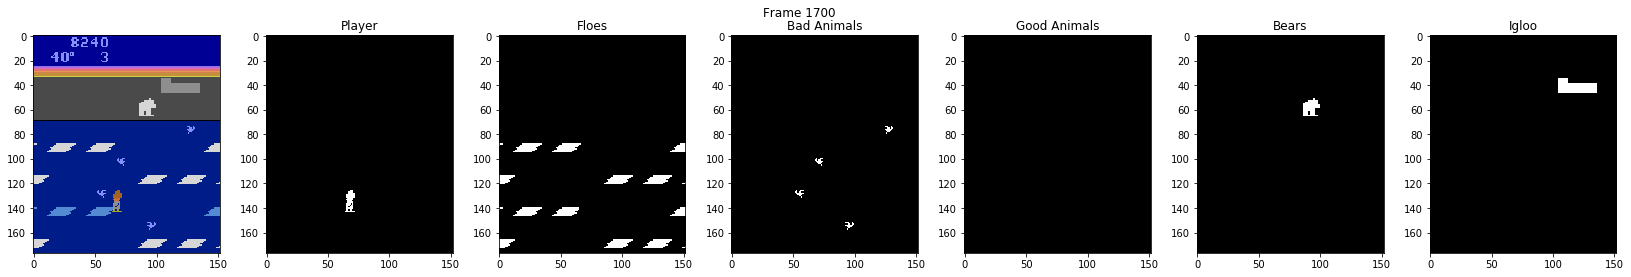

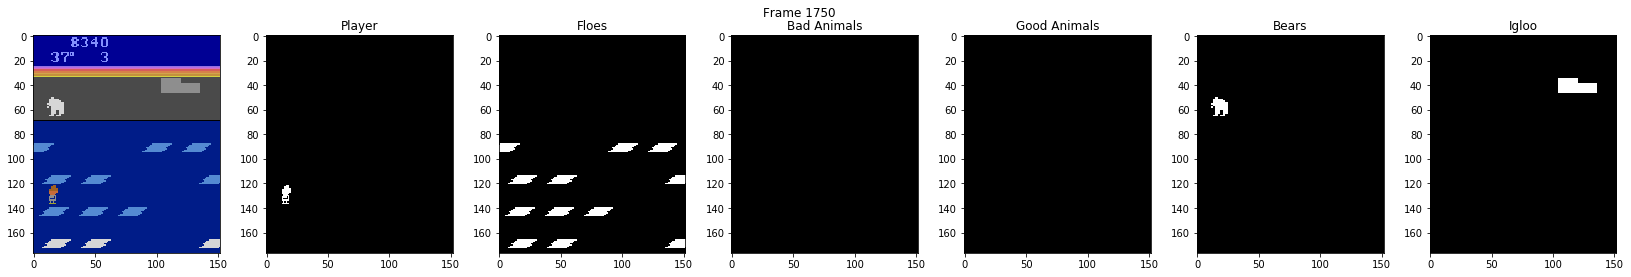

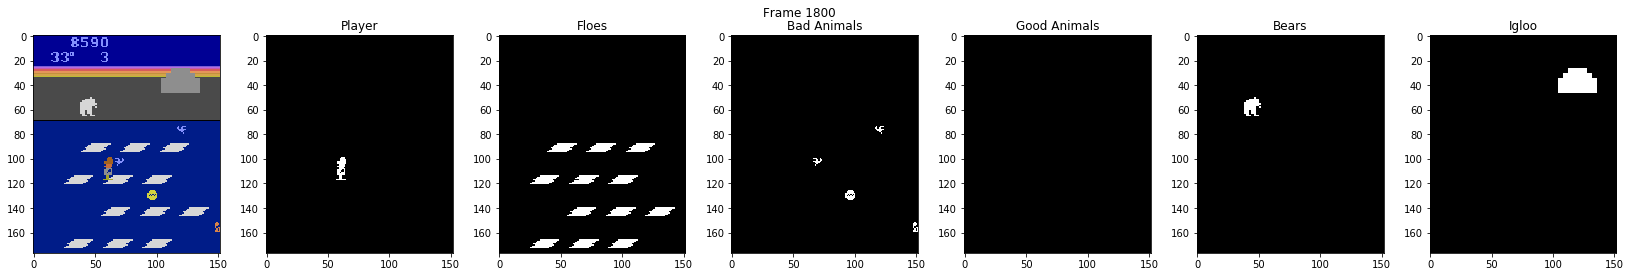

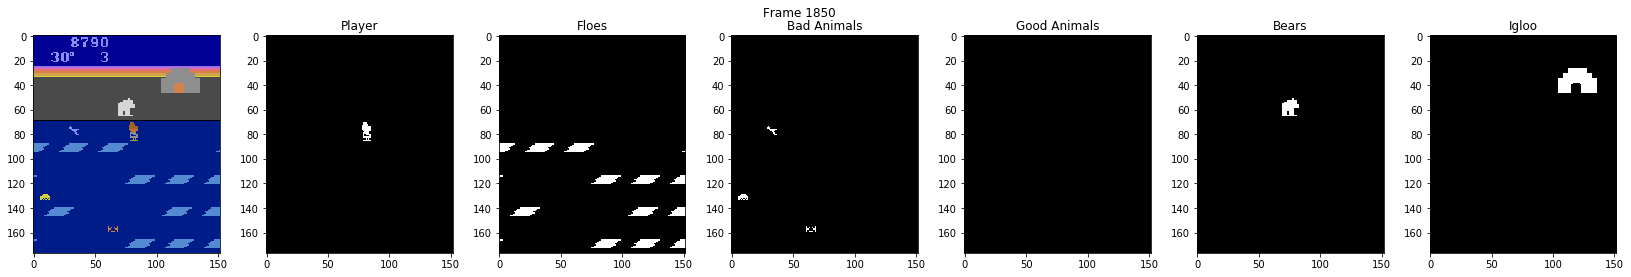

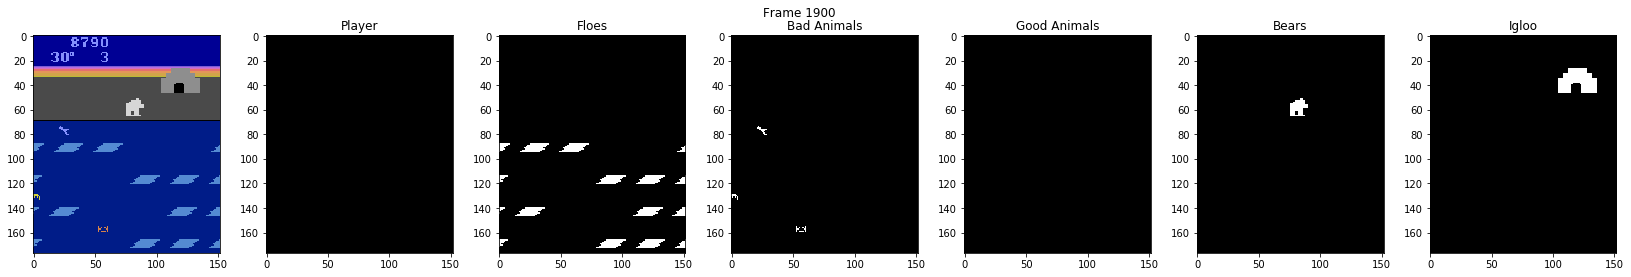

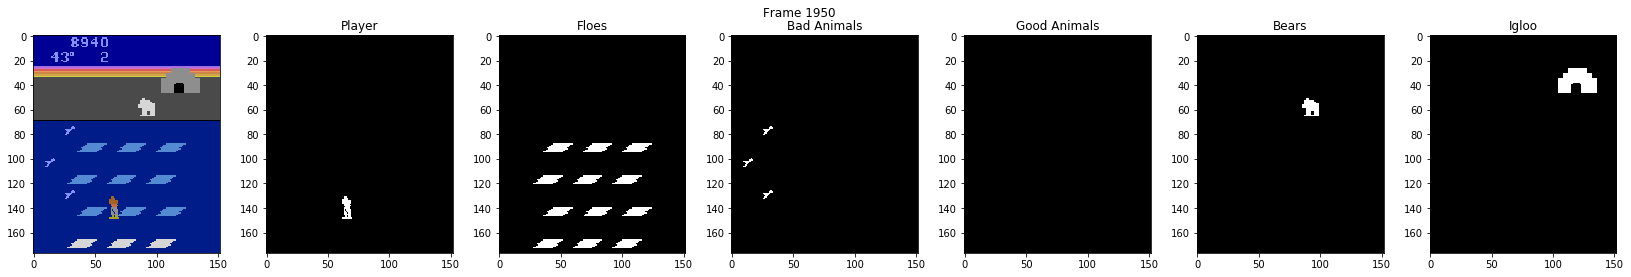

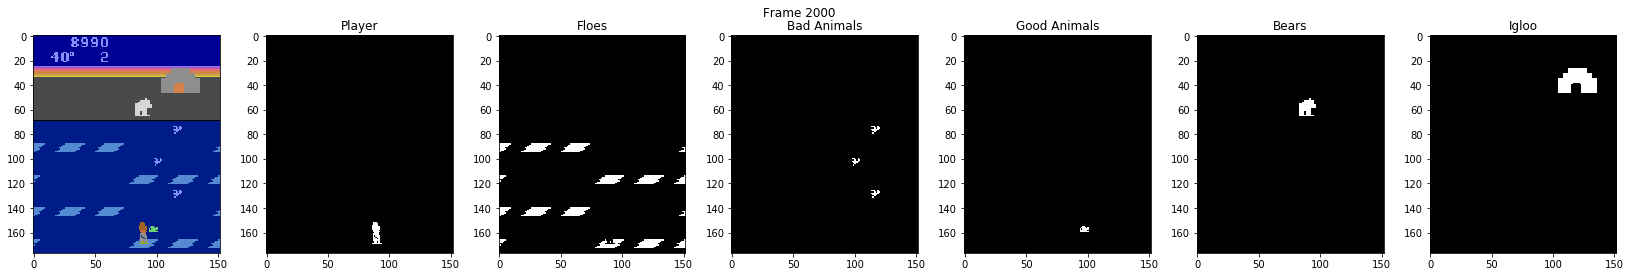

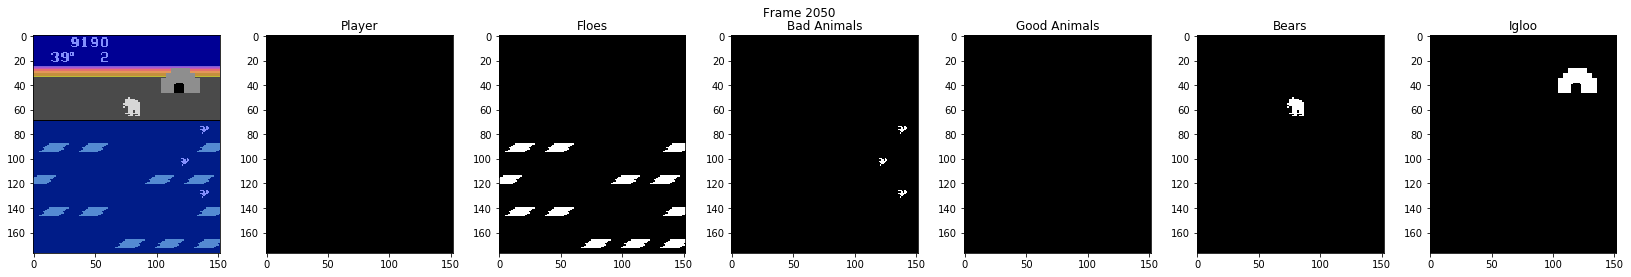

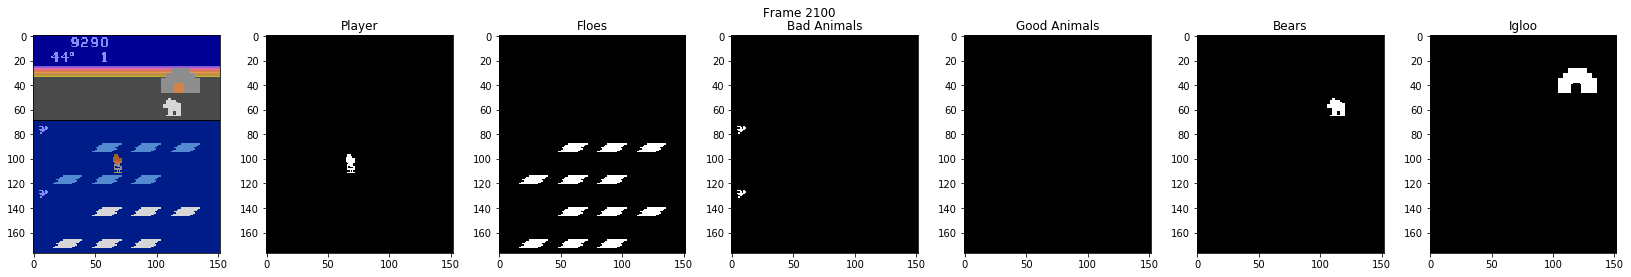

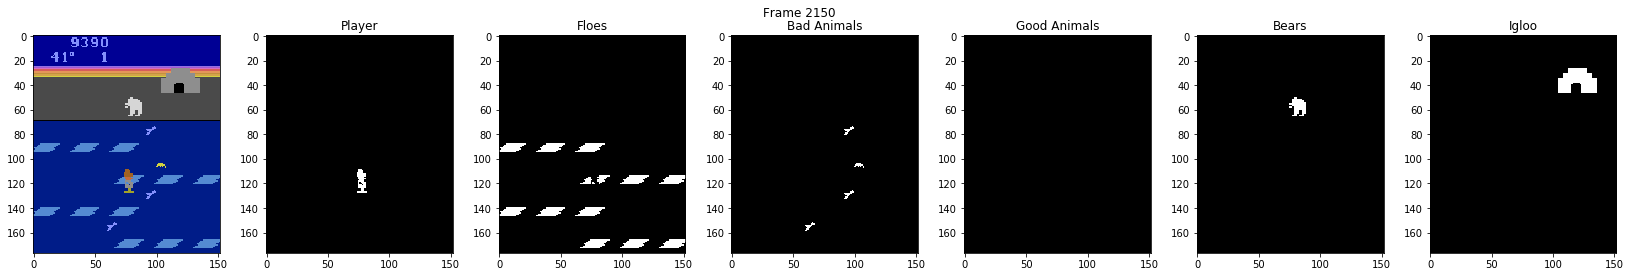

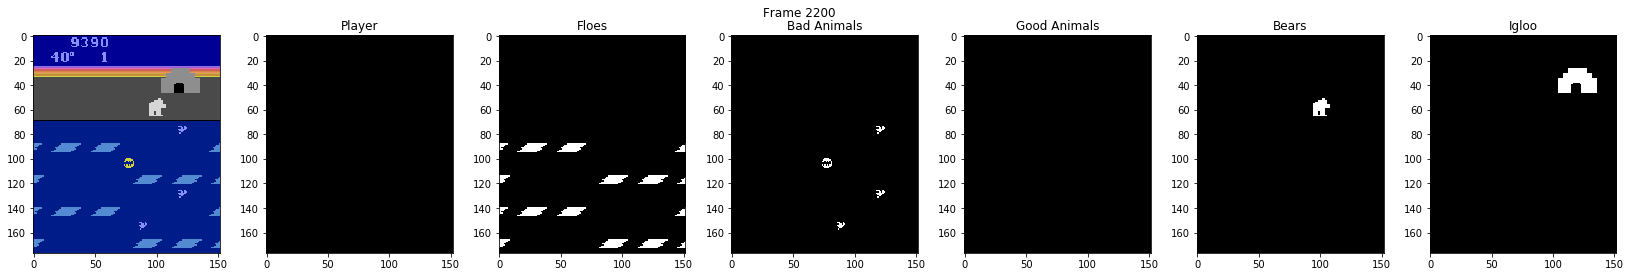

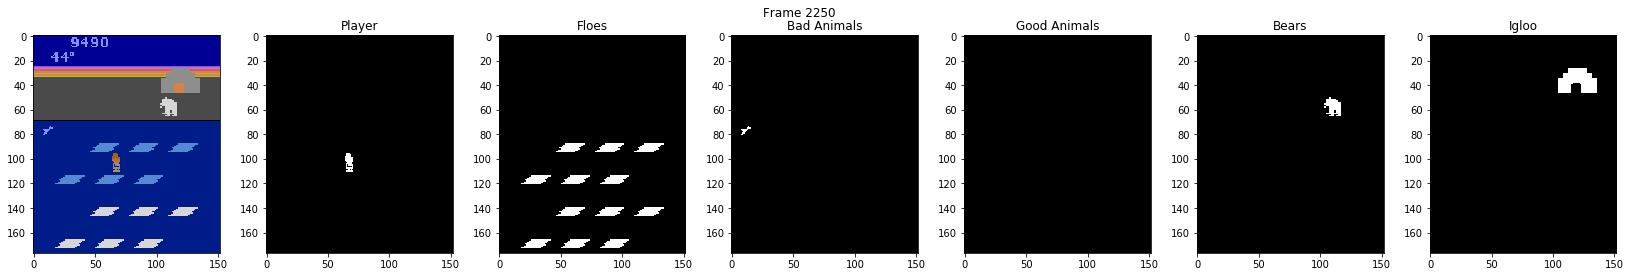

In [227]:
NCOLS = 7

for frame_index in range(0, 2300, 50):
    state_figure = plt.figure(figsize=(NCOLS * COL_WIDTH + WIDTH_SPACING, NROWS * ROW_HEIGHT + HEIGHT_SPACING))
    plt.subplots_adjust(wspace=0.2)
    plt.suptitle(f'Frame {frame_index}')
    
    full_frame = states_300_0_color[frame_index]
    frame = np.moveaxis(full_frame[:, frame_row_min:frame_row_max, frame_col_min:frame_col_max], 0, 2)

    color_ax = plt.subplot(NROWS, NCOLS, 1)
    color_ax.imshow(frame)
    
    for ax_index, (masker, name) in enumerate(zip((player_masker, floe_masker, bad_animal_masker, 
                                                   good_animal_masker, bear_filter, igloo_masker),
                                                  ('Player', 'Floes', 'Bad Animals', 
                                                   'Good Animals', 'Bears', 'Igloo'))):
        ax = plt.subplot(NROWS, NCOLS, ax_index + 2)
        ax.set_title(name)
        ax.imshow(masker(frame), cmap='gray')
    
    plt.show()